# Top-level imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2


#### import packages - setup

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn import metrics
import datetime
import tensorflow as tf

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/pyth

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
data_dir = '../data/'

In [5]:
data_files = os.listdir(data_dir)
data_files.sort()

#### Wild data

In [6]:
fish_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishData.csv', encoding='ISO-8859-1')
site_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteData.csv', encoding='ISO-8859-1')

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
fish_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishInfo.csv', encoding='ISO-8859-1')
site_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteInfo.csv', encoding='ISO-8859-1')

#### Farm data

In [8]:
dfo_data = pd.read_csv(f'{data_dir}DFOSeaLice_Data.csv')
dfo_info = pd.read_csv(f'{data_dir}DFOSeaLice_Info.csv')

In [9]:
industry_data = pd.read_csv(f'{data_dir}IndustrySeaLice_Data.csv', encoding='ISO-8859-1', low_memory=False)
industry_info = pd.read_csv(f'{data_dir}IndustrySeaLice_Info.csv', encoding='ISO-8859-1', low_memory=False)

## Setting overall constants

Things to set here 
- Years to analyse
- Within-season date range
- Accepted ranges
- Resampling dates

In [10]:
analysis_years = list(range(2003, 2018))

analysis_months = list(range(1, 7))

dow_dict = {
    1: 'MON',
    2: 'TUE',
    3: 'WED',
    4: 'THU', 
    5: 'FRI', 
    6: 'SAT', 
    7: 'SUN'
}

def get_dow(dt_obj):
    dow_text = dt_obj.isoweekday()
    return(dow_dict[dow_text])

wild_locations = site_data['location'].unique()

## Setting up response

### Unified adult count
This is one possible response

In [11]:
adult = fish_data[['Lep_PAmale', 'Lep_PAfemale', 
                   'Lep_male', 'Lep_gravid',
                   'Lep_nongravid', 'unid_PA',
                   'unid_adult']].sum(axis=1)

fish_data_date = pd.to_datetime(fish_data[['year', 'day', 'month']])

response = pd.DataFrame({'count':adult.values, 
                         'location':fish_data['location'].values,
                         'datetime': fish_data_date})

response_glacier = response[response['location'] == 'Glacier']



year_df_list = []
for year in analysis_years:
    subset = response_glacier[response_glacier['datetime'].dt.year == year]
    subset.loc[0] = np.nan
    subset.loc[0, 'datetime'] = datetime.datetime(year, 1, 1)
    subset.loc[1] = np.nan
    subset.loc[1, 'datetime'] = datetime.datetime(year, 12, 31)
    subset.sort_values('datetime', inplace=True)
    subset_resampled = subset.resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                       on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_df_list.append(subset_resampled)
Y_glacier = pd.concat(year_df_list)

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [12]:
#Y_glacier.to_csv('../xdata/Y_glacier.csv')

resample by week for average

This is the code I was formerly using for the resampling, it's pretty inconsistent

Y_glacier = response_glacier.resample('W', on='datetime', label='left').apply(np.nanmean)

## Setting up inputs - wild data

## Setting up inputs - wild data

In [13]:
# non-motile lice
juvenile = pd.DataFrame(fish_data[['Lep_cope', 'chalA',
                      'chalB', 'Caligus_cope',
                      'unid_cope', 'chal_unid']].sum(axis=1)).rename({0: 'count'}, axis=1)
juvenile['datetime'] = fish_data_date
juvenile['location'] = fish_data['location']

juvenile = juvenile[juvenile['location'] == 'Glacier']

year_juv_list = []
for year in analysis_years:
    subset = juvenile[juvenile['datetime'].dt.year == year]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_juv_list.append(subset_resample)
X_wild_juv = pd.concat(year_juv_list)

In [14]:
site_data = site_data[site_data['location'] == 'Glacier']

site_data['datetime'] = pd.to_datetime(site_data[['year', 'month', 'day']])

year_temp_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'temp', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_temp_list.append(subset_resample)
X_wild_temp = pd.concat(year_temp_list)

In [15]:
year_sal_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'salt', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(method='linear')
    year_sal_list.append(subset_resample)
X_wild_sal = pd.concat(year_sal_list)

## Setting up inputs - farm data

Inputs that we want

44 - Sargeunts Pass

41 - Doctor Islet

45 - Humphrey Rock

56 - Glacier Falls

54 - Simoom Sound

50 - Burdwood Islands

53 - Sir Edmond Bay

49 - Wicklow Point 

In [16]:
relevant_farms = ['Sargeaunt Pass',
                  'Doctor Islets',
                  'Humphrey Rock',
                  'Simoom Sound*',
                  'Burdwood',
                  'Glacier Falls',
                  'Sir Edmund Bay',
                  'Wicklow Point'
                 ]
relevant_farms_iterable = ['Sargeaunt Pass',
                           'Doctor Islets',
                           'Humphrey Rock',
                           'Burdwood',
                           'Glacier Falls',
                           'Sir Edmund Bay',
                           'Wicklow Point'
                          ]


In [17]:
relevant_farm_data = industry_data[industry_data['Site Common Name'].str.contains('|'.join(relevant_farms))]

relevant_farm_data['Day'] = 1
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
relevant_farm_data['month'] = relevant_farm_data['Month'].map(month_map)
relevant_farm_data['datetime'] = pd.to_datetime(relevant_farm_data[['Year', 'month', 'Day']])

relevant_farm_data = relevant_farm_data[relevant_farm_data['datetime'].dt.year.isin(analysis_years)]

year_industry_list = []
for year in analysis_years:
    subset = relevant_farm_data.loc[(relevant_farm_data['datetime'].dt.year == year), 
                                   ['datetime', 'Site Common Name', 'Average L. salmonis motiles per fish']]
    
    for i, farm in enumerate(relevant_farms_iterable):
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
            
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('Site Common Name').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
#                                                                  on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
                                                                   on='datetime', label='left').sum().interpolate(methods='linear')

    year_industry_list.append(subset_resample)
X_industry = pd.concat(year_industry_list)


/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

## Setting up inputs - weather station

In [18]:
station_dir = '../station_data/'

In [19]:
station_files = os.listdir(station_dir)
station_files = [file for file in station_files if 'en_climate_daily_BC' in file]

stations_to_concat = []
for file in station_files:
    stations_to_concat.append(pd.read_csv(f'{station_dir}{file}'))
station_df = pd.concat(stations_to_concat)
station_df['datetime'] = pd.to_datetime(station_df['Date/Time'])

relevant_station_df = station_df[station_df['datetime'].dt.year.isin(analysis_years)]
year_station_list = []

for year in analysis_years:
    subset = relevant_station_df.loc[(relevant_station_df['datetime'].dt.year == year),
                                    ['datetime', 'Mean Temp (°C)']].rename({'Mean Temp (°C)': 'temp'})
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                      on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_station_list.append(subset_resample)
X_station = pd.concat(year_station_list)


### Forming array for model input

In [20]:
from scipy.ndimage.interpolation import shift

In [21]:
arrays_to_stack = []

for year in analysis_years:
    juv_sub = shift(np.nanmean(X_wild_juv[(X_wild_juv.index.get_level_values(1).year == year) & 
                         X_wild_juv.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1), 3, cval=np.nan)
    temp_sub = np.nanmean(X_wild_temp[(X_wild_temp.index.get_level_values(1).year == year) & 
                          X_wild_temp.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    sal_sub = np.nanmean(X_wild_sal[(X_wild_sal.index.get_level_values(1).year == year) & 
                         X_wild_sal.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    ind_sub = shift(np.nanmean(X_industry[(X_industry.index.get_level_values(1).year == year) & 
                         X_industry.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1), 3, cval=np.nan)
    sta_sub = X_station[(X_station.index.year == year) & 
                         X_station.index.month.isin(analysis_months)].values
    
    year_array = np.column_stack((juv_sub, temp_sub, sal_sub, ind_sub, sta_sub))
    
    # Time lag by 2 weeks
#     year_array = np.concatenate([year_array, np.full([3, 4], np.nan)])
    arrays_to_stack.append(year_array)
    
X = np.stack(arrays_to_stack, axis=0)

In [22]:
X.shape

(15, 26, 5)

In [23]:
arrays_to_stack = []

for year in analysis_years:
    year_Y = Y_glacier[(Y_glacier.index.year == year) & 
                        Y_glacier.index.month.isin(analysis_months)].values
#     arrays_to_stack.append(np.concatenate([np.full([3, 1], np.nan), year_Y]))
    arrays_to_stack.append(year_Y)
    
Y = np.stack(arrays_to_stack, axis=0)

In [24]:
Y.shape

(15, 26, 1)

# Modelling

## Models

### Naive seasonal

In [25]:
def naive_seasonal(year: int, reference_data: pd.DataFrame):
    '''
    Naive seasonal model
    This model takes a year to be predicted in and returns the last known year's values
    
    year: Year to be predicted
    reference_data: Pandas dataframe of the test/input Y data, must have a DatetimeIndex index
    '''
    
    
    pred_subset = reference_data[reference_data.index.year == year]
    preds = pred_subset[pred_subset.index.month.isin(analysis_months)]
    
    return(np.array(preds))

### LSTM

In [26]:
# # Run only to reset logs
# !rm -rf ./logs/ 
# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [27]:
# Helper functions
def plot_predicted_vs_test(pred: np.ndarray, test: np.ndarray):
    fig, ax = plt.subplots(nrows=1, ncols=len(pred))
    fig.set_figwidth(14)
    
    for i in range(len(pred)):
        ax[i].plot(pred[i], color='black')
        ax[i].plot(test[i], color='gray')
        ax[i].set_title(i)   


def convert_zero_to_nan(arr: np.array) -> np.array:
    """
    Convert zeros to nan, this is to revert zeros in the output to nan
    """
    new_arr = arr
    new_arr[new_arr == 0] = np.nan
    return new_arr


def reverse_time_series(arr: np.array) -> np.array:
    """
    Made specifically for arrays where the second dimension is time
    """
    return arr[:, ::-1, :]

Instructions for updating:
Colocations handled automatically by placer.


/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/opt

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
14/14 [==============================] - 3s 228ms/sample - loss: 0.4574
Epoch 2/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4549
Epoch 3/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.4499
Epoch 4/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4385
Epoch 5/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.4238
Epoch 6/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4063
Epoch 7/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3647
Epoch 8/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3182
Epoch 9/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3345
Epoch 10/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.3384
Epoc

14/14 [==============================] - 0s 5ms/sample - loss: 0.2189
Epoch 92/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2258
Epoch 93/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2174
Epoch 94/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2235
Epoch 95/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2270
Epoch 96/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2198
Epoch 97/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2215
Epoch 98/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2283
Epoch 99/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2242
Epoch 100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2201
Epoch 101/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2221
Epoch 102/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2219
Epo

Epoch 188/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1826
Epoch 189/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1942
Epoch 190/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1771
Epoch 191/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1879
Epoch 192/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1840
Epoch 193/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1839
Epoch 194/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1814
Epoch 195/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1869
Epoch 196/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1908
Epoch 197/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1757
Epoch 198/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1855
Epoch 199/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 285/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1708
Epoch 286/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1684
Epoch 287/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1654
Epoch 288/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1578
Epoch 289/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1738
Epoch 290/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1691
Epoch 291/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1611
Epoch 292/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1581
Epoch 293/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1589
Epoch 294/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1539
Epoch 295/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1636
Epoch 296/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 382/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1602
Epoch 383/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1496
Epoch 384/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1473
Epoch 385/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1444
Epoch 386/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1597
Epoch 387/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1560
Epoch 388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1523
Epoch 389/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1450
Epoch 390/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1515
Epoch 391/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1612
Epoch 392/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1471
Epoch 393/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 479/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1410
Epoch 480/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1583
Epoch 481/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1414
Epoch 482/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1355
Epoch 483/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1390
Epoch 484/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1461
Epoch 485/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1414
Epoch 486/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1309
Epoch 487/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1429
Epoch 488/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1358
Epoch 489/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1408
Epoch 490/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 576/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1293
Epoch 577/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1376
Epoch 578/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1376
Epoch 579/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1407
Epoch 580/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 581/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1284
Epoch 582/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1299
Epoch 583/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1351
Epoch 584/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1315
Epoch 585/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1339
Epoch 586/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1344
Epoch 587/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 673/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1204
Epoch 674/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1265
Epoch 675/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1237
Epoch 676/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1218
Epoch 677/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1277
Epoch 678/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1223
Epoch 679/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1299
Epoch 680/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 681/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1290
Epoch 682/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1263
Epoch 683/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1305
Epoch 684/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 770/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1244
Epoch 771/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1265
Epoch 772/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1364
Epoch 773/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1201
Epoch 774/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1232
Epoch 775/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1206
Epoch 776/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1356
Epoch 777/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1329
Epoch 778/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1229
Epoch 779/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1147
Epoch 780/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1217
Epoch 781/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 867/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1160
Epoch 868/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1139
Epoch 869/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1210
Epoch 870/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 871/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1135
Epoch 872/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1202
Epoch 873/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1239
Epoch 874/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1261
Epoch 875/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1152
Epoch 876/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1219
Epoch 877/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1325
Epoch 878/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 964/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1250
Epoch 965/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 966/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1176
Epoch 967/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1180
Epoch 968/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1252
Epoch 969/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1201
Epoch 970/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1140
Epoch 971/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 972/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1213
Epoch 973/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1156
Epoch 974/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1190
Epoch 975/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 1060/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1114
Epoch 1061/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1231
Epoch 1062/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 1063/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1228
Epoch 1064/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 1065/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1162
Epoch 1066/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1208
Epoch 1067/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 1068/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1182
Epoch 1069/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1195
Epoch 1070/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1115
Epoch 1071/2000
14/14 [==============================]

Epoch 1156/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1126
Epoch 1157/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1247
Epoch 1158/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1153
Epoch 1159/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 1160/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1113
Epoch 1161/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1175
Epoch 1162/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1258
Epoch 1163/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1198
Epoch 1164/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 1165/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1174
Epoch 1166/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1083
Epoch 1167/2000
14/14 [==============================]

Epoch 1252/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1161
Epoch 1253/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1105
Epoch 1254/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1255/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1112
Epoch 1256/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1174
Epoch 1257/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1158
Epoch 1258/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1265
Epoch 1259/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1260/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1120
Epoch 1261/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1233
Epoch 1262/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1165
Epoch 1263/2000
14/14 [==============================]

Epoch 1348/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1179
Epoch 1349/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1114
Epoch 1350/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1202
Epoch 1351/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1173
Epoch 1352/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1069
Epoch 1353/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1046
Epoch 1354/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1170
Epoch 1355/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1231
Epoch 1356/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1170
Epoch 1357/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1223
Epoch 1358/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1160
Epoch 1359/2000
14/14 [==============================]

Epoch 1444/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1109
Epoch 1445/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1111
Epoch 1446/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1116
Epoch 1447/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1098
Epoch 1448/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1167
Epoch 1449/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1200
Epoch 1450/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1145
Epoch 1451/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1124
Epoch 1452/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1131
Epoch 1453/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1054
Epoch 1454/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1127
Epoch 1455/2000
14/14 [==============================]

Epoch 1540/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1541/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1188
Epoch 1542/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1122
Epoch 1543/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 1544/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1161
Epoch 1545/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1092
Epoch 1546/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1082
Epoch 1547/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1151
Epoch 1548/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1182
Epoch 1549/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1126
Epoch 1550/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1034
Epoch 1551/2000
14/14 [==============================]

Epoch 1636/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1637/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1110
Epoch 1638/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1019
Epoch 1639/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1059
Epoch 1640/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1084
Epoch 1641/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1041
Epoch 1642/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1029
Epoch 1643/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1044
Epoch 1644/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1143
Epoch 1645/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1157
Epoch 1646/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1043
Epoch 1647/2000
14/14 [==============================]

Epoch 1732/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1192
Epoch 1733/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1118
Epoch 1734/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1051
Epoch 1735/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1061
Epoch 1736/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1150
Epoch 1737/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1093
Epoch 1738/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1074
Epoch 1739/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0996
Epoch 1740/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1020
Epoch 1741/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1742/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1129
Epoch 1743/2000
14/14 [==============================]

Epoch 1828/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1082
Epoch 1829/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1112
Epoch 1830/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1107
Epoch 1831/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1832/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1005
Epoch 1833/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1092
Epoch 1834/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1173
Epoch 1835/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 1836/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1837/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1128
Epoch 1838/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1072
Epoch 1839/2000
14/14 [==============================]

Epoch 1924/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1026
Epoch 1925/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1008
Epoch 1926/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1927/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0994
Epoch 1928/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1032
Epoch 1929/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1002
Epoch 1930/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1041
Epoch 1931/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0986
Epoch 1932/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1024
Epoch 1933/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1048
Epoch 1934/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1935/2000
14/14 [==============================]

Epoch 19/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2764
Epoch 20/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2753
Epoch 21/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2573
Epoch 22/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2528
Epoch 23/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2478
Epoch 24/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2538
Epoch 25/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2492
Epoch 26/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2602
Epoch 27/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2465
Epoch 28/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2437
Epoch 29/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2437
Epoch 30/2000
14/14 [==============================] - 0s 5ms/sample - loss:

Epoch 117/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1828
Epoch 118/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1815
Epoch 119/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1836
Epoch 120/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1999
Epoch 121/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1749
Epoch 122/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1786
Epoch 123/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1741
Epoch 124/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1943
Epoch 125/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1825
Epoch 126/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1844
Epoch 127/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1784
Epoch 128/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 214/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1601
Epoch 215/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1554
Epoch 216/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1685
Epoch 217/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1468
Epoch 218/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1665
Epoch 219/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1536
Epoch 220/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1549
Epoch 221/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1537
Epoch 222/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1593
Epoch 223/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1610
Epoch 224/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1563
Epoch 225/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 311/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1454
Epoch 312/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1464
Epoch 313/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1404
Epoch 314/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1315
Epoch 315/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1416
Epoch 316/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1446
Epoch 317/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1392
Epoch 318/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1334
Epoch 319/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1369
Epoch 320/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1380
Epoch 321/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1374
Epoch 322/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 408/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1235
Epoch 409/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1282
Epoch 410/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1193
Epoch 411/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1230
Epoch 412/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1088
Epoch 413/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1219
Epoch 414/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1222
Epoch 415/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1215
Epoch 416/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1174
Epoch 417/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1193
Epoch 418/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1234
Epoch 419/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 505/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1108
Epoch 506/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1250
Epoch 507/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1137
Epoch 508/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1161
Epoch 509/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1078
Epoch 510/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1107
Epoch 511/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1192
Epoch 512/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1184
Epoch 513/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1112
Epoch 514/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1172
Epoch 515/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1189
Epoch 516/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 602/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1086
Epoch 603/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1068
Epoch 604/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1103
Epoch 605/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1179
Epoch 606/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1139
Epoch 607/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1052
Epoch 608/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1103
Epoch 609/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1191
Epoch 610/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1019
Epoch 611/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1232
Epoch 612/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1066
Epoch 613/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 699/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1074
Epoch 700/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1028
Epoch 701/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1064
Epoch 702/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1008
Epoch 703/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1135
Epoch 704/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1093
Epoch 705/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1103
Epoch 706/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1141
Epoch 707/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1088
Epoch 708/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1043
Epoch 709/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1039
Epoch 710/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 796/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1040
Epoch 797/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1022
Epoch 798/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1009
Epoch 799/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0998
Epoch 800/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1006
Epoch 801/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0991
Epoch 802/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1122
Epoch 803/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0994
Epoch 804/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1143
Epoch 805/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1122
Epoch 806/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1005
Epoch 807/2000
14/14 [==============================] - 0s 7ms/sa

Epoch 893/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1072
Epoch 894/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0907
Epoch 895/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0962
Epoch 896/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0938
Epoch 897/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1148
Epoch 898/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1032
Epoch 899/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1008
Epoch 900/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1010
Epoch 901/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1074
Epoch 902/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1051
Epoch 903/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1009
Epoch 904/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 990/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0980
Epoch 991/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0936
Epoch 992/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1009
Epoch 993/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0971
Epoch 994/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1005
Epoch 995/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1064
Epoch 996/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0967
Epoch 997/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1003
Epoch 998/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0981
Epoch 999/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0885
Epoch 1000/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0904
Epoch 1001/2000
14/14 [==============================] - 0s 4ms/

Epoch 1086/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0911
Epoch 1087/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1001
Epoch 1088/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0862
Epoch 1089/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0910
Epoch 1090/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0925
Epoch 1091/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0896
Epoch 1092/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0936
Epoch 1093/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0885
Epoch 1094/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0974
Epoch 1095/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0942
Epoch 1096/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0959
Epoch 1097/2000
14/14 [==============================]

Epoch 1182/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0820
Epoch 1183/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0845
Epoch 1184/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0912
Epoch 1185/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0925
Epoch 1186/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0886
Epoch 1187/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0820
Epoch 1188/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0921
Epoch 1189/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0870
Epoch 1190/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0881
Epoch 1191/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0893
Epoch 1192/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0919
Epoch 1193/2000
14/14 [==============================]

Epoch 1278/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0964
Epoch 1279/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0898
Epoch 1280/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0875
Epoch 1281/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0888
Epoch 1282/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0903
Epoch 1283/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0951
Epoch 1284/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0924
Epoch 1285/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0960
Epoch 1286/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1024
Epoch 1287/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0912
Epoch 1288/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0909
Epoch 1289/2000
14/14 [==============================]

Epoch 1374/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0988
Epoch 1375/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0930
Epoch 1376/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0945
Epoch 1377/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0872
Epoch 1378/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0865
Epoch 1379/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0896
Epoch 1380/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0822
Epoch 1381/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0883
Epoch 1382/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0880
Epoch 1383/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0857
Epoch 1384/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0851
Epoch 1385/2000
14/14 [==============================]

Epoch 1470/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0894
Epoch 1471/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0851
Epoch 1472/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0875
Epoch 1473/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0950
Epoch 1474/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0990
Epoch 1475/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0879
Epoch 1476/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0870
Epoch 1477/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0841
Epoch 1478/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0797
Epoch 1479/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0894
Epoch 1480/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0874
Epoch 1481/2000
14/14 [==============================]

Epoch 1566/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0901
Epoch 1567/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0917
Epoch 1568/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0921
Epoch 1569/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0913
Epoch 1570/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0948
Epoch 1571/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0916
Epoch 1572/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0943
Epoch 1573/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0919
Epoch 1574/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0951
Epoch 1575/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0859
Epoch 1576/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0906
Epoch 1577/2000
14/14 [==============================]

Epoch 1662/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0820
Epoch 1663/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0858
Epoch 1664/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0906
Epoch 1665/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0858
Epoch 1666/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0896
Epoch 1667/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0873
Epoch 1668/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0902
Epoch 1669/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0840
Epoch 1670/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0852
Epoch 1671/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0974
Epoch 1672/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0812
Epoch 1673/2000
14/14 [==============================]

Epoch 1758/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0846
Epoch 1759/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0869
Epoch 1760/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0903
Epoch 1761/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0865
Epoch 1762/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0897
Epoch 1763/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0753
Epoch 1764/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0812
Epoch 1765/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0792
Epoch 1766/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0825
Epoch 1767/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0882
Epoch 1768/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0830
Epoch 1769/2000
14/14 [==============================]

Epoch 1854/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0839
Epoch 1855/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0757
Epoch 1856/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0894
Epoch 1857/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0831
Epoch 1858/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0853
Epoch 1859/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0848
Epoch 1860/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0851
Epoch 1861/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0890
Epoch 1862/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0809
Epoch 1863/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0814
Epoch 1864/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0829
Epoch 1865/2000
14/14 [==============================]

Epoch 1950/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0786
Epoch 1951/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0841
Epoch 1952/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0835
Epoch 1953/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0848
Epoch 1954/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0829
Epoch 1955/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0821
Epoch 1956/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0782
Epoch 1957/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0843
Epoch 1958/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0879
Epoch 1959/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0834
Epoch 1960/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0772
Epoch 1961/2000
14/14 [==============================]

Epoch 45/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2384
Epoch 46/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2477
Epoch 47/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2498
Epoch 48/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2500
Epoch 49/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2427
Epoch 50/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2358
Epoch 51/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2470
Epoch 52/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2454
Epoch 53/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2449
Epoch 54/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2395
Epoch 55/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2315
Epoch 56/2000
14/14 [==============================] - 0s 4ms/sample - loss:

14/14 [==============================] - 0s 4ms/sample - loss: 0.1888
Epoch 143/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1832
Epoch 144/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1826
Epoch 145/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1847
Epoch 146/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1849
Epoch 147/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1747
Epoch 148/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1795
Epoch 149/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1795
Epoch 150/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1837
Epoch 151/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1912
Epoch 152/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1799
Epoch 153/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.

Epoch 239/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1563
Epoch 240/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1569
Epoch 241/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1616
Epoch 242/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1551
Epoch 243/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1552
Epoch 244/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1619
Epoch 245/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1489
Epoch 246/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1558
Epoch 247/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1602
Epoch 248/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1625
Epoch 249/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1581
Epoch 250/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 336/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1437
Epoch 337/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1512
Epoch 338/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1375
Epoch 339/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1431
Epoch 340/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1469
Epoch 341/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1542
Epoch 342/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1445
Epoch 343/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1476
Epoch 344/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1337
Epoch 345/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1476
Epoch 346/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1476
Epoch 347/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 433/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1293
Epoch 434/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1378
Epoch 435/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1352
Epoch 436/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1348
Epoch 437/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1298
Epoch 438/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1321
Epoch 439/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1322
Epoch 440/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1348
Epoch 441/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1375
Epoch 442/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1312
Epoch 443/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1292
Epoch 444/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 530/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1193
Epoch 531/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1208
Epoch 532/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1264
Epoch 533/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1228
Epoch 534/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1255
Epoch 535/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1273
Epoch 536/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1217
Epoch 537/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1226
Epoch 538/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1271
Epoch 539/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1201
Epoch 540/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1283
Epoch 541/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 627/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1194
Epoch 628/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1290
Epoch 629/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 630/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1236
Epoch 631/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1106
Epoch 632/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1217
Epoch 633/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1197
Epoch 634/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1241
Epoch 635/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1215
Epoch 636/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1176
Epoch 637/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1168
Epoch 638/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 724/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1212
Epoch 725/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1209
Epoch 726/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1237
Epoch 727/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1156
Epoch 728/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1212
Epoch 729/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1166
Epoch 730/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1182
Epoch 731/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1238
Epoch 732/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1154
Epoch 733/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1174
Epoch 734/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1120
Epoch 735/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 821/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1106
Epoch 822/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1078
Epoch 823/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1155
Epoch 824/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1270
Epoch 825/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1164
Epoch 826/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1147
Epoch 827/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1215
Epoch 828/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1234
Epoch 829/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1155
Epoch 830/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1183
Epoch 831/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1207
Epoch 832/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 918/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 919/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1149
Epoch 920/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1164
Epoch 921/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1094
Epoch 922/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1092
Epoch 923/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1184
Epoch 924/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1057
Epoch 925/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 926/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1169
Epoch 927/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1166
Epoch 928/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1141
Epoch 929/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 1015/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1078
Epoch 1016/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1076
Epoch 1017/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1053
Epoch 1018/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1161
Epoch 1019/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1071
Epoch 1020/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1122
Epoch 1021/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1056
Epoch 1022/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1078
Epoch 1023/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1146
Epoch 1024/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1025/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1104
Epoch 1026/2000
14/14 [==============================]

Epoch 1111/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0975
Epoch 1112/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1113/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0997
Epoch 1114/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 1115/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1048
Epoch 1116/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1041
Epoch 1117/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1083
Epoch 1118/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1055
Epoch 1119/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1072
Epoch 1120/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1161
Epoch 1121/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0998
Epoch 1122/2000
14/14 [==============================]

Epoch 1207/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1031
Epoch 1208/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1046
Epoch 1209/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1145
Epoch 1210/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1232
Epoch 1211/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1118
Epoch 1212/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1034
Epoch 1213/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1142
Epoch 1214/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1040
Epoch 1215/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1094
Epoch 1216/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1025
Epoch 1217/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1120
Epoch 1218/2000
14/14 [==============================]

Epoch 1303/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1110
Epoch 1304/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1104
Epoch 1305/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0999
Epoch 1306/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1132
Epoch 1307/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1027
Epoch 1308/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1038
Epoch 1309/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1067
Epoch 1310/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1037
Epoch 1311/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0997
Epoch 1312/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1313/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0967
Epoch 1314/2000
14/14 [==============================]

Epoch 1399/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0936
Epoch 1400/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1103
Epoch 1401/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1081
Epoch 1402/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1132
Epoch 1403/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1093
Epoch 1404/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1088
Epoch 1405/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1008
Epoch 1406/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1137
Epoch 1407/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1230
Epoch 1408/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1261
Epoch 1409/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1281
Epoch 1410/2000
14/14 [==============================]

Epoch 1495/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1058
Epoch 1496/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1003
Epoch 1497/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1037
Epoch 1498/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1044
Epoch 1499/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1006
Epoch 1500/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1126
Epoch 1501/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1080
Epoch 1502/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1503/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1100
Epoch 1504/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1031
Epoch 1505/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0957
Epoch 1506/2000
14/14 [==============================]

Epoch 1591/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0992
Epoch 1592/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1167
Epoch 1593/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1080
Epoch 1594/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0969
Epoch 1595/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1108
Epoch 1596/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1116
Epoch 1597/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1042
Epoch 1598/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0939
Epoch 1599/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0954
Epoch 1600/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0939
Epoch 1601/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1060
Epoch 1602/2000
14/14 [==============================]

Epoch 1687/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0960
Epoch 1688/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0989
Epoch 1689/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1005
Epoch 1690/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0917
Epoch 1691/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1008
Epoch 1692/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0901
Epoch 1693/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0980
Epoch 1694/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1045
Epoch 1695/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0970
Epoch 1696/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1023
Epoch 1697/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1022
Epoch 1698/2000
14/14 [==============================]

Epoch 1783/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0942
Epoch 1784/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0989
Epoch 1785/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0977
Epoch 1786/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0967
Epoch 1787/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1038
Epoch 1788/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1083
Epoch 1789/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1075
Epoch 1790/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1058
Epoch 1791/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1034
Epoch 1792/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0968
Epoch 1793/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0982
Epoch 1794/2000
14/14 [==============================]

Epoch 1879/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0938
Epoch 1880/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0963
Epoch 1881/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0958
Epoch 1882/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1007
Epoch 1883/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0911
Epoch 1884/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1027
Epoch 1885/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0883
Epoch 1886/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0992
Epoch 1887/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1008
Epoch 1888/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0945
Epoch 1889/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1066
Epoch 1890/2000
14/14 [==============================]

Epoch 1975/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0947
Epoch 1976/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1003
Epoch 1977/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0942
Epoch 1978/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0980
Epoch 1979/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0896
Epoch 1980/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0961
Epoch 1981/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0914
Epoch 1982/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0978
Epoch 1983/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1000
Epoch 1984/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0943
Epoch 1985/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0926
Epoch 1986/2000
14/14 [==============================]

Epoch 71/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2465
Epoch 72/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2240
Epoch 73/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2259
Epoch 74/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2221
Epoch 75/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2460
Epoch 76/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2172
Epoch 77/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2243
Epoch 78/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2280
Epoch 79/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2372
Epoch 80/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2262
Epoch 81/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2194
Epoch 82/2000
14/14 [==============================] - 0s 5ms/sample - loss:

Epoch 168/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1778
Epoch 169/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1829
Epoch 170/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1837
Epoch 171/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1826
Epoch 172/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1668
Epoch 173/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1669
Epoch 174/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1627
Epoch 175/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1611
Epoch 176/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1677
Epoch 177/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1786
Epoch 178/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1657
Epoch 179/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 265/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1575
Epoch 266/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1491
Epoch 267/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1547
Epoch 268/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1514
Epoch 269/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1497
Epoch 270/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1564
Epoch 271/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1407
Epoch 272/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1551
Epoch 273/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1515
Epoch 274/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1576
Epoch 275/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 276/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 362/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.1349
Epoch 363/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1327
Epoch 364/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1341
Epoch 365/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1376
Epoch 366/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1293
Epoch 367/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1340
Epoch 368/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1360
Epoch 369/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1353
Epoch 370/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1417
Epoch 371/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1351
Epoch 372/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1345
Epoch 373/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 459/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1245
Epoch 460/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1243
Epoch 461/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1211
Epoch 462/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1279
Epoch 463/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1252
Epoch 464/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1276
Epoch 465/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1249
Epoch 466/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1217
Epoch 467/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1222
Epoch 468/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1294
Epoch 469/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1229
Epoch 470/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 556/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1252
Epoch 557/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1220
Epoch 558/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1154
Epoch 559/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1187
Epoch 560/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1230
Epoch 561/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1251
Epoch 562/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1195
Epoch 563/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1167
Epoch 564/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1105
Epoch 565/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1098
Epoch 566/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1142
Epoch 567/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 653/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1245
Epoch 654/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1232
Epoch 655/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1105
Epoch 656/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1140
Epoch 657/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1186
Epoch 658/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 659/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1099
Epoch 660/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1260
Epoch 661/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1114
Epoch 662/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1150
Epoch 663/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1275
Epoch 664/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 750/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1059
Epoch 751/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1107
Epoch 752/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1047
Epoch 753/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1085
Epoch 754/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1090
Epoch 755/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1014
Epoch 756/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1143
Epoch 757/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1080
Epoch 758/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1171
Epoch 759/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1049
Epoch 760/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1128
Epoch 761/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 847/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1093
Epoch 848/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1088
Epoch 849/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1149
Epoch 850/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1094
Epoch 851/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0991
Epoch 852/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1057
Epoch 853/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1085
Epoch 854/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1038
Epoch 855/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1070
Epoch 856/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1063
Epoch 857/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1072
Epoch 858/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 944/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1029
Epoch 945/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1014
Epoch 946/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0952
Epoch 947/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1049
Epoch 948/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1081
Epoch 949/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0999
Epoch 950/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1029
Epoch 951/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1129
Epoch 952/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1017
Epoch 953/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0983
Epoch 954/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1040
Epoch 955/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1040/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1072
Epoch 1041/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1001
Epoch 1042/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1120
Epoch 1043/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1044/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0948
Epoch 1045/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1058
Epoch 1046/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1012
Epoch 1047/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0978
Epoch 1048/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1065
Epoch 1049/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0959
Epoch 1050/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1102
Epoch 1051/2000
14/14 [==============================]

Epoch 1136/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1075
Epoch 1137/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0946
Epoch 1138/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0998
Epoch 1139/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0974
Epoch 1140/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0927
Epoch 1141/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1142/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0964
Epoch 1143/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1045
Epoch 1144/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1045
Epoch 1145/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1014
Epoch 1146/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1053
Epoch 1147/2000
14/14 [==============================]

Epoch 1232/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1042
Epoch 1233/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1048
Epoch 1234/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1012
Epoch 1235/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1102
Epoch 1236/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1146
Epoch 1237/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 1238/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1043
Epoch 1239/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1075
Epoch 1240/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1006
Epoch 1241/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0991
Epoch 1242/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1059
Epoch 1243/2000
14/14 [==============================]

Epoch 1328/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0857
Epoch 1329/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0948
Epoch 1330/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1028
Epoch 1331/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0893
Epoch 1332/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0972
Epoch 1333/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0924
Epoch 1334/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0953
Epoch 1335/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0932
Epoch 1336/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0971
Epoch 1337/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1015
Epoch 1338/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1056
Epoch 1339/2000
14/14 [==============================]

Epoch 1424/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0949
Epoch 1425/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0923
Epoch 1426/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1015
Epoch 1427/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1070
Epoch 1428/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0975
Epoch 1429/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1001
Epoch 1430/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0946
Epoch 1431/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0883
Epoch 1432/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0972
Epoch 1433/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0941
Epoch 1434/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0916
Epoch 1435/2000
14/14 [==============================]

Epoch 1520/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0857
Epoch 1521/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0988
Epoch 1522/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0832
Epoch 1523/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0937
Epoch 1524/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0843
Epoch 1525/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0940
Epoch 1526/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0982
Epoch 1527/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0952
Epoch 1528/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1008
Epoch 1529/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0985
Epoch 1530/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0942
Epoch 1531/2000
14/14 [==============================]

Epoch 1616/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0928
Epoch 1617/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0947
Epoch 1618/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1016
Epoch 1619/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1620/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1037
Epoch 1621/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1042
Epoch 1622/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1054
Epoch 1623/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0917
Epoch 1624/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1051
Epoch 1625/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1003
Epoch 1626/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0958
Epoch 1627/2000
14/14 [==============================]

Epoch 1712/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0920
Epoch 1713/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0881
Epoch 1714/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0917
Epoch 1715/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0946
Epoch 1716/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0985
Epoch 1717/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0896
Epoch 1718/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0829
Epoch 1719/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0958
Epoch 1720/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0873
Epoch 1721/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0969
Epoch 1722/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0966
Epoch 1723/2000
14/14 [==============================]

Epoch 1808/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0951
Epoch 1809/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0923
Epoch 1810/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0918
Epoch 1811/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0828
Epoch 1812/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0854
Epoch 1813/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0922
Epoch 1814/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0871
Epoch 1815/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0867
Epoch 1816/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0871
Epoch 1817/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0830
Epoch 1818/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0874
Epoch 1819/2000
14/14 [==============================]

Epoch 1904/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0860
Epoch 1905/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0872
Epoch 1906/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0933
Epoch 1907/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0908
Epoch 1908/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0890
Epoch 1909/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0825
Epoch 1910/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0852
Epoch 1911/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0836
Epoch 1912/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0834
Epoch 1913/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0818
Epoch 1914/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0890
Epoch 1915/2000
14/14 [==============================]

Epoch 2000/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0868
###################
Train MAE for 2006 is 0.016859886496119306
Test MAE for 2006 is 0.5079037877203914
###################
Epoch 1/2000
14/14 [==============================] - 5s 350ms/sample - loss: 0.4689
Epoch 2/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.4624
Epoch 3/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.4598
Epoch 4/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4574
Epoch 5/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4528
Epoch 6/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4433
Epoch 7/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4355
Epoch 8/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4080
Epoch 9/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3867
Epoch 10/2000
14/14 [=====================

14/14 [==============================] - 0s 4ms/sample - loss: 0.2111
Epoch 97/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2116
Epoch 98/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2506
Epoch 99/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2214
Epoch 100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2151
Epoch 101/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2096
Epoch 102/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2214
Epoch 103/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2191
Epoch 104/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2199
Epoch 105/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2241
Epoch 106/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2205
Epoch 107/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.214

Epoch 193/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1779
Epoch 194/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1829
Epoch 195/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1751
Epoch 196/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1799
Epoch 197/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1786
Epoch 198/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1819
Epoch 199/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1743
Epoch 200/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1763
Epoch 201/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1832
Epoch 202/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1883
Epoch 203/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1740
Epoch 204/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 290/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1546
Epoch 291/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1590
Epoch 292/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1604
Epoch 293/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1645
Epoch 294/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1642
Epoch 295/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1618
Epoch 296/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1599
Epoch 297/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1601
Epoch 298/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1683
Epoch 299/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1724
Epoch 300/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1604
Epoch 301/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 387/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1409
Epoch 388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1497
Epoch 389/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1530
Epoch 390/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1594
Epoch 391/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1434
Epoch 392/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1534
Epoch 393/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1511
Epoch 394/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1472
Epoch 395/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1415
Epoch 396/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1413
Epoch 397/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1424
Epoch 398/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 484/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1347
Epoch 485/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1318
Epoch 486/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1433
Epoch 487/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1421
Epoch 488/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1362
Epoch 489/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1296
Epoch 490/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1360
Epoch 491/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1344
Epoch 492/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1392
Epoch 493/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1429
Epoch 494/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1429
Epoch 495/2000
14/14 [==============================] - 0s 6ms/sa

Epoch 581/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1330
Epoch 582/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1358
Epoch 583/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1312
Epoch 584/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1354
Epoch 585/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 586/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1352
Epoch 587/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1303
Epoch 588/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1296
Epoch 589/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1293
Epoch 590/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1317
Epoch 591/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 592/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 678/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1209
Epoch 679/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1169
Epoch 680/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1238
Epoch 681/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1212
Epoch 682/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1257
Epoch 683/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1305
Epoch 684/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1250
Epoch 685/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1217
Epoch 686/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1209
Epoch 687/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1210
Epoch 688/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1186
Epoch 689/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 775/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1140
Epoch 776/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1232
Epoch 777/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1137
Epoch 778/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1171
Epoch 779/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1188
Epoch 780/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1188
Epoch 781/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1128
Epoch 782/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1132
Epoch 783/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1099
Epoch 784/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1244
Epoch 785/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1161
Epoch 786/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 872/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1121
Epoch 873/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1129
Epoch 874/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1149
Epoch 875/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1161
Epoch 876/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1140
Epoch 877/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1138
Epoch 878/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1115
Epoch 879/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1127
Epoch 880/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1155
Epoch 881/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1163
Epoch 882/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1246
Epoch 883/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 969/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1112
Epoch 970/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1118
Epoch 971/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1234
Epoch 972/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1089
Epoch 973/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1108
Epoch 974/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1060
Epoch 975/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1143
Epoch 976/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1064
Epoch 977/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1072
Epoch 978/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1181
Epoch 979/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1116
Epoch 980/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 1065/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1073
Epoch 1066/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1020
Epoch 1067/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1075
Epoch 1068/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 1069/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1110
Epoch 1070/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1098
Epoch 1071/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1105
Epoch 1072/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1033
Epoch 1073/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1036
Epoch 1074/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1045
Epoch 1075/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1082
Epoch 1076/2000
14/14 [==============================]

Epoch 1161/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1162/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1131
Epoch 1163/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1135
Epoch 1164/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1004
Epoch 1165/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1100
Epoch 1166/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1110
Epoch 1167/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1002
Epoch 1168/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1131
Epoch 1169/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1199
Epoch 1170/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1232
Epoch 1171/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1154
Epoch 1172/2000
14/14 [==============================]

Epoch 1257/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1071
Epoch 1258/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1055
Epoch 1259/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1064
Epoch 1260/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1073
Epoch 1261/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1026
Epoch 1262/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1263/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0938
Epoch 1264/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0941
Epoch 1265/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0924
Epoch 1266/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1078
Epoch 1267/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1036
Epoch 1268/2000
14/14 [==============================]

Epoch 1353/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1045
Epoch 1354/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1099
Epoch 1355/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0970
Epoch 1356/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1053
Epoch 1357/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1050
Epoch 1358/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0967
Epoch 1359/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1065
Epoch 1360/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1100
Epoch 1361/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1020
Epoch 1362/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0975
Epoch 1363/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1007
Epoch 1364/2000
14/14 [==============================]

Epoch 1449/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1050
Epoch 1450/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1042
Epoch 1451/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0991
Epoch 1452/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1018
Epoch 1453/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0924
Epoch 1454/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0921
Epoch 1455/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1035
Epoch 1456/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1117
Epoch 1457/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1032
Epoch 1458/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0961
Epoch 1459/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0937
Epoch 1460/2000
14/14 [==============================]

Epoch 1545/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1027
Epoch 1546/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1016
Epoch 1547/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0931
Epoch 1548/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1003
Epoch 1549/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1173
Epoch 1550/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1141
Epoch 1551/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1236
Epoch 1552/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1087
Epoch 1553/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1031
Epoch 1554/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1086
Epoch 1555/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1556/2000
14/14 [==============================]

Epoch 1641/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0960
Epoch 1642/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0962
Epoch 1643/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0947
Epoch 1644/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0979
Epoch 1645/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0927
Epoch 1646/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0945
Epoch 1647/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0936
Epoch 1648/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0948
Epoch 1649/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0988
Epoch 1650/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1020
Epoch 1651/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0881
Epoch 1652/2000
14/14 [==============================]

Epoch 1737/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0999
Epoch 1738/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0911
Epoch 1739/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1042
Epoch 1740/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0970
Epoch 1741/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1053
Epoch 1742/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0990
Epoch 1743/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1045
Epoch 1744/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0989
Epoch 1745/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1025
Epoch 1746/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0988
Epoch 1747/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0980
Epoch 1748/2000
14/14 [==============================]

Epoch 1833/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0996
Epoch 1834/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1036
Epoch 1835/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1194
Epoch 1836/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1097
Epoch 1837/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0995
Epoch 1838/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1020
Epoch 1839/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0864
Epoch 1840/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0981
Epoch 1841/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0989
Epoch 1842/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0987
Epoch 1843/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0976
Epoch 1844/2000
14/14 [==============================]

Epoch 1929/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0972
Epoch 1930/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0914
Epoch 1931/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1044
Epoch 1932/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0912
Epoch 1933/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1047
Epoch 1934/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0953
Epoch 1935/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0940
Epoch 1936/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0970
Epoch 1937/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1052
Epoch 1938/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1087
Epoch 1939/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1087
Epoch 1940/2000
14/14 [==============================]

Epoch 24/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2821
Epoch 25/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2830
Epoch 26/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2929
Epoch 27/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3013
Epoch 28/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2880
Epoch 29/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2674
Epoch 30/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2914
Epoch 31/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2844
Epoch 32/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2994
Epoch 33/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2852
Epoch 34/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2775
Epoch 35/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 122/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2189
Epoch 123/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2084
Epoch 124/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2049
Epoch 125/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2117
Epoch 126/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2074
Epoch 127/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2160
Epoch 128/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2137
Epoch 129/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2091
Epoch 130/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2204
Epoch 131/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2098
Epoch 132/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2093
Epoch 133/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 219/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1851
Epoch 220/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1917
Epoch 221/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1822
Epoch 222/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1894
Epoch 223/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1794
Epoch 224/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1936
Epoch 225/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1886
Epoch 226/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1832
Epoch 227/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1686
Epoch 228/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1801
Epoch 229/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1760
Epoch 230/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 316/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1615
Epoch 317/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1600
Epoch 318/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1578
Epoch 319/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1563
Epoch 320/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1669
Epoch 321/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1609
Epoch 322/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1679
Epoch 323/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1548
Epoch 324/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1554
Epoch 325/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1678
Epoch 326/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1581
Epoch 327/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 413/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1557
Epoch 414/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1601
Epoch 415/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1590
Epoch 416/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1559
Epoch 417/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1539
Epoch 418/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1480
Epoch 419/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1557
Epoch 420/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1593
Epoch 421/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1541
Epoch 422/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1595
Epoch 423/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1504
Epoch 424/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 510/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1536
Epoch 511/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1512
Epoch 512/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1420
Epoch 513/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1586
Epoch 514/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1435
Epoch 515/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1508
Epoch 516/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1418
Epoch 517/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1471
Epoch 518/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1469
Epoch 519/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1417
Epoch 520/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1463
Epoch 521/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 607/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1449
Epoch 608/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1486
Epoch 609/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1392
Epoch 610/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1408
Epoch 611/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1427
Epoch 612/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1463
Epoch 613/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1489
Epoch 614/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1459
Epoch 615/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1482
Epoch 616/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1441
Epoch 617/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1422
Epoch 618/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 704/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1393
Epoch 705/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1391
Epoch 706/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1402
Epoch 707/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1394
Epoch 708/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1359
Epoch 709/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1475
Epoch 710/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1396
Epoch 711/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1424
Epoch 712/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1447
Epoch 713/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1420
Epoch 714/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1477
Epoch 715/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 801/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1403
Epoch 802/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1276
Epoch 803/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1367
Epoch 804/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1316
Epoch 805/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1359
Epoch 806/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1288
Epoch 807/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1375
Epoch 808/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1398
Epoch 809/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1395
Epoch 810/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1348
Epoch 811/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1324
Epoch 812/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 898/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1365
Epoch 899/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1353
Epoch 900/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1300
Epoch 901/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1430
Epoch 902/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1384
Epoch 903/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1373
Epoch 904/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1409
Epoch 905/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1403
Epoch 906/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1331
Epoch 907/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1331
Epoch 908/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1411
Epoch 909/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 995/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1282
Epoch 996/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1387
Epoch 997/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1282
Epoch 998/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1307
Epoch 999/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1365
Epoch 1000/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 1001/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1288
Epoch 1002/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1256
Epoch 1003/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1257
Epoch 1004/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1330
Epoch 1005/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1305
Epoch 1006/2000
14/14 [==============================] - 0s

Epoch 1091/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 1092/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1363
Epoch 1093/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1345
Epoch 1094/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1303
Epoch 1095/2000
14/14 [==============================] - 0s 8ms/sample - loss: 0.1332
Epoch 1096/2000
14/14 [==============================] - 0s 8ms/sample - loss: 0.1334
Epoch 1097/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.1270
Epoch 1098/2000
14/14 [==============================] - 0s 8ms/sample - loss: 0.1405
Epoch 1099/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1316
Epoch 1100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1292
Epoch 1101/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1363
Epoch 1102/2000
14/14 [==============================]

Epoch 1187/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1333
Epoch 1188/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1300
Epoch 1189/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1339
Epoch 1190/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1338
Epoch 1191/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1265
Epoch 1192/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1291
Epoch 1193/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1347
Epoch 1194/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1373
Epoch 1195/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1292
Epoch 1196/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1265
Epoch 1197/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1255
Epoch 1198/2000
14/14 [==============================]

Epoch 1283/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1314
Epoch 1284/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1269
Epoch 1285/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1294
Epoch 1286/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1301
Epoch 1287/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1172
Epoch 1288/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1250
Epoch 1289/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1223
Epoch 1290/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1237
Epoch 1291/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1259
Epoch 1292/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1228
Epoch 1293/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1243
Epoch 1294/2000
14/14 [==============================]

Epoch 1379/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1258
Epoch 1380/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1212
Epoch 1381/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1262
Epoch 1382/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1367
Epoch 1383/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1244
Epoch 1384/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1286
Epoch 1385/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1367
Epoch 1386/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1321
Epoch 1387/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1252
Epoch 1388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1384
Epoch 1389/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1301
Epoch 1390/2000
14/14 [==============================]

Epoch 1475/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1196
Epoch 1476/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1182
Epoch 1477/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1227
Epoch 1478/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1223
Epoch 1479/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1274
Epoch 1480/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1350
Epoch 1481/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1238
Epoch 1482/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1195
Epoch 1483/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1233
Epoch 1484/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1154
Epoch 1485/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1310
Epoch 1486/2000
14/14 [==============================]

Epoch 1571/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1209
Epoch 1572/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1231
Epoch 1573/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1232
Epoch 1574/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1248
Epoch 1575/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1360
Epoch 1576/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1232
Epoch 1577/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1258
Epoch 1578/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1166
Epoch 1579/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1191
Epoch 1580/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1216
Epoch 1581/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1185
Epoch 1582/2000
14/14 [==============================]

Epoch 1667/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1081
Epoch 1668/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1153
Epoch 1669/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1226
Epoch 1670/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1176
Epoch 1671/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1151
Epoch 1672/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1222
Epoch 1673/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1257
Epoch 1674/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1285
Epoch 1675/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1219
Epoch 1676/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1165
Epoch 1677/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1678/2000
14/14 [==============================]

Epoch 1763/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1202
Epoch 1764/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1179
Epoch 1765/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1219
Epoch 1766/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1245
Epoch 1767/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1131
Epoch 1768/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1105
Epoch 1769/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1240
Epoch 1770/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1294
Epoch 1771/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1246
Epoch 1772/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1198
Epoch 1773/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1190
Epoch 1774/2000
14/14 [==============================]

Epoch 1859/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1111
Epoch 1860/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1204
Epoch 1861/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1862/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1015
Epoch 1863/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1058
Epoch 1864/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1095
Epoch 1865/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1050
Epoch 1866/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1058
Epoch 1867/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1071
Epoch 1868/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1059
Epoch 1869/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1164
Epoch 1870/2000
14/14 [==============================]

Epoch 1955/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1211
Epoch 1956/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1122
Epoch 1957/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1006
Epoch 1958/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1134
Epoch 1959/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1072
Epoch 1960/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1120
Epoch 1961/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1144
Epoch 1962/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1109
Epoch 1963/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1104
Epoch 1964/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1126
Epoch 1965/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1017
Epoch 1966/2000
14/14 [==============================]

14/14 [==============================] - 0s 4ms/sample - loss: 0.2500
Epoch 51/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2520
Epoch 52/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2467
Epoch 53/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2402
Epoch 54/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2488
Epoch 55/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2452
Epoch 56/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2450
Epoch 57/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2326
Epoch 58/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2408
Epoch 59/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2459
Epoch 60/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2461
Epoch 61/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2422
Epoch 

14/14 [==============================] - 0s 5ms/sample - loss: 0.1913
Epoch 148/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1958
Epoch 149/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1972
Epoch 150/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1898
Epoch 151/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1868
Epoch 152/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2023
Epoch 153/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1894
Epoch 154/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1993
Epoch 155/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1873
Epoch 156/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1825
Epoch 157/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1966
Epoch 158/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.

Epoch 244/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1861
Epoch 245/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1739
Epoch 246/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1808
Epoch 247/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1713
Epoch 248/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1690
Epoch 249/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1808
Epoch 250/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1756
Epoch 251/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1781
Epoch 252/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1736
Epoch 253/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1730
Epoch 254/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1618
Epoch 255/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 341/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1597
Epoch 342/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1593
Epoch 343/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1590
Epoch 344/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1618
Epoch 345/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1581
Epoch 346/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1578
Epoch 347/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1600
Epoch 348/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1576
Epoch 349/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1584
Epoch 350/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1665
Epoch 351/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1485
Epoch 352/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 438/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1511
Epoch 439/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1436
Epoch 440/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1604
Epoch 441/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1449
Epoch 442/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1466
Epoch 443/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1500
Epoch 444/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1506
Epoch 445/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1523
Epoch 446/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1495
Epoch 447/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1511
Epoch 448/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1470
Epoch 449/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 535/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1366
Epoch 536/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1386
Epoch 537/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1440
Epoch 538/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1391
Epoch 539/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1465
Epoch 540/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1437
Epoch 541/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1418
Epoch 542/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1490
Epoch 543/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1422
Epoch 544/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1403
Epoch 545/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1435
Epoch 546/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 632/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1384
Epoch 633/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1512
Epoch 634/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1549
Epoch 635/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1490
Epoch 636/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1423
Epoch 637/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1411
Epoch 638/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1439
Epoch 639/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1419
Epoch 640/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1394
Epoch 641/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1431
Epoch 642/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1397
Epoch 643/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 729/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1320
Epoch 730/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1311
Epoch 731/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1360
Epoch 732/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1435
Epoch 733/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1482
Epoch 734/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1338
Epoch 735/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1356
Epoch 736/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1406
Epoch 737/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1389
Epoch 738/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1388
Epoch 739/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1286
Epoch 740/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 826/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1330
Epoch 827/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1237
Epoch 828/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1347
Epoch 829/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1405
Epoch 830/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1357
Epoch 831/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1299
Epoch 832/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1310
Epoch 833/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1351
Epoch 834/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1246
Epoch 835/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1346
Epoch 836/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1355
Epoch 837/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 923/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1476
Epoch 924/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1350
Epoch 925/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1387
Epoch 926/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1280
Epoch 927/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1304
Epoch 928/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1398
Epoch 929/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1264
Epoch 930/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1282
Epoch 931/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1370
Epoch 932/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1261
Epoch 933/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1342
Epoch 934/2000
14/14 [==============================] - 0s 5ms/sa

14/14 [==============================] - 0s 5ms/sample - loss: 0.1217
Epoch 1020/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1320
Epoch 1021/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1215
Epoch 1022/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1289
Epoch 1023/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1228
Epoch 1024/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1253
Epoch 1025/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1227
Epoch 1026/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1213
Epoch 1027/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1358
Epoch 1028/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1293
Epoch 1029/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1323
Epoch 1030/2000
14/14 [==============================] - 0s 5ms/sample

Epoch 1115/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1352
Epoch 1116/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1253
Epoch 1117/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1311
Epoch 1118/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1288
Epoch 1119/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1273
Epoch 1120/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1315
Epoch 1121/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1327
Epoch 1122/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1269
Epoch 1123/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1256
Epoch 1124/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1274
Epoch 1125/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1329
Epoch 1126/2000
14/14 [==============================]

Epoch 1211/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1254
Epoch 1212/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1251
Epoch 1213/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1241
Epoch 1214/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1226
Epoch 1215/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1319
Epoch 1216/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1331
Epoch 1217/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1257
Epoch 1218/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1336
Epoch 1219/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1239
Epoch 1220/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1219
Epoch 1221/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1217
Epoch 1222/2000
14/14 [==============================]

Epoch 1307/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1206
Epoch 1308/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1157
Epoch 1309/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1213
Epoch 1310/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1254
Epoch 1311/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1160
Epoch 1312/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1226
Epoch 1313/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1264
Epoch 1314/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1337
Epoch 1315/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1262
Epoch 1316/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1192
Epoch 1317/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1233
Epoch 1318/2000
14/14 [==============================]

Epoch 1403/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1206
Epoch 1404/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1236
Epoch 1405/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1247
Epoch 1406/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1278
Epoch 1407/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1359
Epoch 1408/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1231
Epoch 1409/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1218
Epoch 1410/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1218
Epoch 1411/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1199
Epoch 1412/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1208
Epoch 1413/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1195
Epoch 1414/2000
14/14 [==============================]

Epoch 1499/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1189
Epoch 1500/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1233
Epoch 1501/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1252
Epoch 1502/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1212
Epoch 1503/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1277
Epoch 1504/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1209
Epoch 1505/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1187
Epoch 1506/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1215
Epoch 1507/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1252
Epoch 1508/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1273
Epoch 1509/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 1510/2000
14/14 [==============================]

Epoch 1595/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1226
Epoch 1596/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1199
Epoch 1597/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1289
Epoch 1598/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1208
Epoch 1599/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1300
Epoch 1600/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1280
Epoch 1601/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1261
Epoch 1602/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1175
Epoch 1603/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1192
Epoch 1604/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1172
Epoch 1605/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1221
Epoch 1606/2000
14/14 [==============================]

Epoch 1691/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1126
Epoch 1692/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1157
Epoch 1693/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1184
Epoch 1694/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1159
Epoch 1695/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1113
Epoch 1696/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1112
Epoch 1697/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1221
Epoch 1698/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 1699/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1169
Epoch 1700/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1196
Epoch 1701/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1237
Epoch 1702/2000
14/14 [==============================]

Epoch 1787/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1139
Epoch 1788/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1140
Epoch 1789/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1147
Epoch 1790/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1154
Epoch 1791/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1208
Epoch 1792/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1116
Epoch 1793/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1794/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1138
Epoch 1795/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1159
Epoch 1796/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1216
Epoch 1797/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1161
Epoch 1798/2000
14/14 [==============================]

Epoch 1883/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1183
Epoch 1884/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1111
Epoch 1885/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1098
Epoch 1886/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1088
Epoch 1887/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1116
Epoch 1888/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1220
Epoch 1889/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1169
Epoch 1890/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1219
Epoch 1891/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1094
Epoch 1892/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1173
Epoch 1893/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1187
Epoch 1894/2000
14/14 [==============================]

Epoch 1979/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1143
Epoch 1980/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1223
Epoch 1981/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1199
Epoch 1982/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1106
Epoch 1983/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1167
Epoch 1984/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1985/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1081
Epoch 1986/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1135
Epoch 1987/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1176
Epoch 1988/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1092
Epoch 1989/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1102
Epoch 1990/2000
14/14 [==============================]

Epoch 75/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2358
Epoch 76/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2351
Epoch 77/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2266
Epoch 78/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2324
Epoch 79/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2318
Epoch 80/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2189
Epoch 81/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2322
Epoch 82/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2291
Epoch 83/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2298
Epoch 84/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2254
Epoch 85/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2207
Epoch 86/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 172/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2019
Epoch 173/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1858
Epoch 174/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1906
Epoch 175/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1831
Epoch 176/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1923
Epoch 177/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1897
Epoch 178/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1792
Epoch 179/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1826
Epoch 180/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1891
Epoch 181/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1920
Epoch 182/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1816
Epoch 183/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 269/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1707
Epoch 270/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1656
Epoch 271/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1736
Epoch 272/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1641
Epoch 273/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1665
Epoch 274/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1558
Epoch 275/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1703
Epoch 276/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.1662
Epoch 277/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1733
Epoch 278/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1526
Epoch 279/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1729
Epoch 280/2000
14/14 [==============================] - 0s 6ms/sa

Epoch 366/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1512
Epoch 367/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1502
Epoch 368/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1498
Epoch 369/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1530
Epoch 370/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1523
Epoch 371/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1580
Epoch 372/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1451
Epoch 373/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1564
Epoch 374/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1448
Epoch 375/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1448
Epoch 376/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1473
Epoch 377/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 463/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1482
Epoch 464/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1326
Epoch 465/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1509
Epoch 466/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1382
Epoch 467/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1404
Epoch 468/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1460
Epoch 469/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1368
Epoch 470/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1332
Epoch 471/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1530
Epoch 472/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1571
Epoch 473/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1429
Epoch 474/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 560/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1442
Epoch 561/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1319
Epoch 562/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1292
Epoch 563/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1469
Epoch 564/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1281
Epoch 565/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1292
Epoch 566/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1389
Epoch 567/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1332
Epoch 568/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1239
Epoch 569/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1277
Epoch 570/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1376
Epoch 571/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 657/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1441
Epoch 658/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1344
Epoch 659/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1259
Epoch 660/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1323
Epoch 661/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1338
Epoch 662/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1263
Epoch 663/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1238
Epoch 664/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1440
Epoch 665/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1295
Epoch 666/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1289
Epoch 667/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1365
Epoch 668/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 754/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1267
Epoch 755/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1183
Epoch 756/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1256
Epoch 757/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1314
Epoch 758/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1146
Epoch 759/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1203
Epoch 760/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1387
Epoch 761/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1408
Epoch 762/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1163
Epoch 763/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1141
Epoch 764/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1231
Epoch 765/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 851/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1178
Epoch 852/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1156
Epoch 853/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1118
Epoch 854/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1253
Epoch 855/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1224
Epoch 856/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1139
Epoch 857/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1092
Epoch 858/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1156
Epoch 859/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1241
Epoch 860/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1197
Epoch 861/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1113
Epoch 862/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 948/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1178
Epoch 949/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1138
Epoch 950/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1121
Epoch 951/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1098
Epoch 952/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1056
Epoch 953/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1184
Epoch 954/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1085
Epoch 955/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1107
Epoch 956/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1075
Epoch 957/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1068
Epoch 958/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1190
Epoch 959/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1044/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1170
Epoch 1045/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1077
Epoch 1046/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1102
Epoch 1047/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1219
Epoch 1048/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1144
Epoch 1049/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1239
Epoch 1050/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1134
Epoch 1051/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1100
Epoch 1052/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1212
Epoch 1053/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1083
Epoch 1054/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1157
Epoch 1055/2000
14/14 [==============================]

Epoch 1140/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 1141/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1119
Epoch 1142/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1145
Epoch 1143/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1102
Epoch 1144/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1046
Epoch 1145/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0991
Epoch 1146/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1072
Epoch 1147/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1134
Epoch 1148/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1121
Epoch 1149/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1031
Epoch 1150/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1063
Epoch 1151/2000
14/14 [==============================]

Epoch 1236/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1111
Epoch 1237/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0983
Epoch 1238/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1081
Epoch 1239/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1063
Epoch 1240/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1033
Epoch 1241/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1059
Epoch 1242/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1063
Epoch 1243/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1022
Epoch 1244/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1100
Epoch 1245/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1032
Epoch 1246/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1094
Epoch 1247/2000
14/14 [==============================]

Epoch 1332/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1155
Epoch 1333/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1131
Epoch 1334/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1335/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1102
Epoch 1336/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1091
Epoch 1337/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1142
Epoch 1338/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1106
Epoch 1339/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0984
Epoch 1340/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1030
Epoch 1341/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1104
Epoch 1342/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1153
Epoch 1343/2000
14/14 [==============================]

Epoch 1428/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1095
Epoch 1429/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1054
Epoch 1430/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0985
Epoch 1431/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1019
Epoch 1432/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1021
Epoch 1433/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1028
Epoch 1434/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1060
Epoch 1435/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1167
Epoch 1436/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1101
Epoch 1437/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1044
Epoch 1438/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1121
Epoch 1439/2000
14/14 [==============================]

Epoch 1524/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1029
Epoch 1525/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0946
Epoch 1526/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1082
Epoch 1527/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1071
Epoch 1528/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1011
Epoch 1529/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1016
Epoch 1530/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1047
Epoch 1531/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0997
Epoch 1532/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0985
Epoch 1533/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1089
Epoch 1534/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1094
Epoch 1535/2000
14/14 [==============================]

Epoch 1620/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1023
Epoch 1621/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1066
Epoch 1622/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1019
Epoch 1623/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1006
Epoch 1624/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0981
Epoch 1625/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0971
Epoch 1626/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0989
Epoch 1627/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1037
Epoch 1628/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0946
Epoch 1629/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0991
Epoch 1630/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1086
Epoch 1631/2000
14/14 [==============================]

Epoch 1716/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1059
Epoch 1717/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1043
Epoch 1718/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0966
Epoch 1719/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1058
Epoch 1720/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1070
Epoch 1721/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1022
Epoch 1722/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0987
Epoch 1723/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0971
Epoch 1724/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0943
Epoch 1725/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0976
Epoch 1726/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1104
Epoch 1727/2000
14/14 [==============================]

Epoch 1812/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0992
Epoch 1813/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0975
Epoch 1814/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1026
Epoch 1815/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1041
Epoch 1816/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1001
Epoch 1817/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1002
Epoch 1818/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1101
Epoch 1819/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1060
Epoch 1820/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0927
Epoch 1821/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1117
Epoch 1822/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1014
Epoch 1823/2000
14/14 [==============================]

Epoch 1908/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.0996
Epoch 1909/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0951
Epoch 1910/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0873
Epoch 1911/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0989
Epoch 1912/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0887
Epoch 1913/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1027
Epoch 1914/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0969
Epoch 1915/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.0986
Epoch 1916/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1048
Epoch 1917/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0943
Epoch 1918/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0937
Epoch 1919/2000
14/14 [==============================]

Epoch 2/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4592
Epoch 3/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4548
Epoch 4/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.4481
Epoch 5/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4358
Epoch 6/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.4218
Epoch 7/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3976
Epoch 8/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3573
Epoch 9/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3306
Epoch 10/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3815
Epoch 11/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3458
Epoch 12/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3162
Epoch 13/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3115


Epoch 100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2066
Epoch 101/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2188
Epoch 102/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2162
Epoch 103/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1996
Epoch 104/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2088
Epoch 105/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2095
Epoch 106/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2062
Epoch 107/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2035
Epoch 108/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2099
Epoch 109/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2121
Epoch 110/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1988
Epoch 111/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 197/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1963
Epoch 198/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1817
Epoch 199/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1812
Epoch 200/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1865
Epoch 201/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1756
Epoch 202/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1843
Epoch 203/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1839
Epoch 204/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1828
Epoch 205/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1837
Epoch 206/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1814
Epoch 207/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1741
Epoch 208/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 294/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1619
Epoch 295/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1702
Epoch 296/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1684
Epoch 297/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1599
Epoch 298/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1660
Epoch 299/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1599
Epoch 300/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1630
Epoch 301/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1642
Epoch 302/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1676
Epoch 303/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1687
Epoch 304/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1735
Epoch 305/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 391/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1523
Epoch 392/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1556
Epoch 393/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1526
Epoch 394/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1573
Epoch 395/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1537
Epoch 396/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1564
Epoch 397/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1540
Epoch 398/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1495
Epoch 399/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1478
Epoch 400/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1602
Epoch 401/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1479
Epoch 402/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 488/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1411
Epoch 489/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1397
Epoch 490/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1478
Epoch 491/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1540
Epoch 492/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1409
Epoch 493/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1427
Epoch 494/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1303
Epoch 495/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1342
Epoch 496/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1409
Epoch 497/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1423
Epoch 498/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1384
Epoch 499/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 585/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1384
Epoch 586/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1349
Epoch 587/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1331
Epoch 588/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1337
Epoch 589/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1345
Epoch 590/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1322
Epoch 591/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1310
Epoch 592/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1329
Epoch 593/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1284
Epoch 594/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1327
Epoch 595/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1378
Epoch 596/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 682/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1268
Epoch 683/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1378
Epoch 684/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1292
Epoch 685/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1286
Epoch 686/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1227
Epoch 687/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1370
Epoch 688/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1382
Epoch 689/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1292
Epoch 690/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1365
Epoch 691/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1250
Epoch 692/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1239
Epoch 693/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 779/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1304
Epoch 780/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1258
Epoch 781/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1275
Epoch 782/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1249
Epoch 783/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1235
Epoch 784/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1237
Epoch 785/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1259
Epoch 786/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1148
Epoch 787/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1192
Epoch 788/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1242
Epoch 789/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1259
Epoch 790/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 876/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1213
Epoch 877/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1283
Epoch 878/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1292
Epoch 879/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1323
Epoch 880/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1324
Epoch 881/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1270
Epoch 882/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1246
Epoch 883/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1251
Epoch 884/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1250
Epoch 885/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1225
Epoch 886/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1202
Epoch 887/2000
14/14 [==============================] - 0s 6ms/sa

Epoch 973/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1170
Epoch 974/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1212
Epoch 975/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1196
Epoch 976/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1155
Epoch 977/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1183
Epoch 978/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1170
Epoch 979/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1236
Epoch 980/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1285
Epoch 981/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1253
Epoch 982/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 983/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1216
Epoch 984/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1069/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1226
Epoch 1070/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1217
Epoch 1071/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1143
Epoch 1072/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1172
Epoch 1073/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1173
Epoch 1074/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1151
Epoch 1075/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1202
Epoch 1076/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1215
Epoch 1077/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1277
Epoch 1078/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1226
Epoch 1079/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1269
Epoch 1080/2000
14/14 [==============================]

Epoch 1165/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1171
Epoch 1166/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1174
Epoch 1167/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1184
Epoch 1168/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1166
Epoch 1169/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1221
Epoch 1170/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1249
Epoch 1171/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1166
Epoch 1172/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1245
Epoch 1173/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1252
Epoch 1174/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1168
Epoch 1175/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1126
Epoch 1176/2000
14/14 [==============================]

Epoch 1261/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1131
Epoch 1262/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1197
Epoch 1263/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1169
Epoch 1264/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1171
Epoch 1265/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1142
Epoch 1266/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1049
Epoch 1267/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1104
Epoch 1268/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1116
Epoch 1269/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1210
Epoch 1270/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1175
Epoch 1271/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1159
Epoch 1272/2000
14/14 [==============================]

Epoch 1357/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1115
Epoch 1358/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1137
Epoch 1359/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1121
Epoch 1360/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1009
Epoch 1361/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1116
Epoch 1362/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1158
Epoch 1363/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1088
Epoch 1364/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1158
Epoch 1365/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1184
Epoch 1366/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1148
Epoch 1367/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1072
Epoch 1368/2000
14/14 [==============================]

Epoch 1453/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1109
Epoch 1454/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1122
Epoch 1455/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1183
Epoch 1456/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1160
Epoch 1457/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1092
Epoch 1458/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1112
Epoch 1459/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 1460/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1131
Epoch 1461/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 1462/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1129
Epoch 1463/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1082
Epoch 1464/2000
14/14 [==============================]

Epoch 1549/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1107
Epoch 1550/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1155
Epoch 1551/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1059
Epoch 1552/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1104
Epoch 1553/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1165
Epoch 1554/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1166
Epoch 1555/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1556/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1105
Epoch 1557/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1149
Epoch 1558/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1214
Epoch 1559/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1175
Epoch 1560/2000
14/14 [==============================]

Epoch 1645/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1092
Epoch 1646/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1114
Epoch 1647/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1111
Epoch 1648/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1121
Epoch 1649/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1094
Epoch 1650/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1088
Epoch 1651/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1099
Epoch 1652/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1083
Epoch 1653/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1141
Epoch 1654/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1215
Epoch 1655/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1139
Epoch 1656/2000
14/14 [==============================]

Epoch 1741/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1173
Epoch 1742/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1126
Epoch 1743/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1093
Epoch 1744/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1144
Epoch 1745/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1118
Epoch 1746/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1158
Epoch 1747/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1017
Epoch 1748/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1749/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1181
Epoch 1750/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1751/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1092
Epoch 1752/2000
14/14 [==============================]

Epoch 1837/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1097
Epoch 1838/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1028
Epoch 1839/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1019
Epoch 1840/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1090
Epoch 1841/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1120
Epoch 1842/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1041
Epoch 1843/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1046
Epoch 1844/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1063
Epoch 1845/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1145
Epoch 1846/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1847/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1094
Epoch 1848/2000
14/14 [==============================]

Epoch 1933/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1036
Epoch 1934/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1084
Epoch 1935/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1096
Epoch 1936/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1113
Epoch 1937/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1066
Epoch 1938/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1129
Epoch 1939/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1098
Epoch 1940/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1021
Epoch 1941/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1107
Epoch 1942/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1079
Epoch 1943/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1134
Epoch 1944/2000
14/14 [==============================]

Epoch 28/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2817
Epoch 29/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2628
Epoch 30/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2762
Epoch 31/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2829
Epoch 32/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2555
Epoch 33/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2602
Epoch 34/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2601
Epoch 35/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2482
Epoch 36/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2554
Epoch 37/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2496
Epoch 38/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2565
Epoch 39/2000
14/14 [==============================] - 0s 5ms/sample - loss:

Epoch 126/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2001
Epoch 127/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2050
Epoch 128/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2046
Epoch 129/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2043
Epoch 130/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1982
Epoch 131/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1942
Epoch 132/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1957
Epoch 133/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1970
Epoch 134/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2118
Epoch 135/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2037
Epoch 136/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1980
Epoch 137/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 223/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1783
Epoch 224/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1832
Epoch 225/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1830
Epoch 226/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1802
Epoch 227/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1768
Epoch 228/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1820
Epoch 229/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1765
Epoch 230/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1722
Epoch 231/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1744
Epoch 232/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1866
Epoch 233/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1778
Epoch 234/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 320/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1668
Epoch 321/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1788
Epoch 322/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1743
Epoch 323/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1706
Epoch 324/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1681
Epoch 325/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1643
Epoch 326/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1640
Epoch 327/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1776
Epoch 328/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1717
Epoch 329/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1674
Epoch 330/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1596
Epoch 331/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 417/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1532
Epoch 418/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1489
Epoch 419/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1448
Epoch 420/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1513
Epoch 421/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1502
Epoch 422/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1508
Epoch 423/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1481
Epoch 424/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1473
Epoch 425/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1495
Epoch 426/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1478
Epoch 427/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1511
Epoch 428/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 514/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1396
Epoch 515/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1431
Epoch 516/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1466
Epoch 517/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1409
Epoch 518/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1541
Epoch 519/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1528
Epoch 520/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1421
Epoch 521/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1463
Epoch 522/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1452
Epoch 523/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1445
Epoch 524/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1452
Epoch 525/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 611/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1410
Epoch 612/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1415
Epoch 613/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1442
Epoch 614/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1420
Epoch 615/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1412
Epoch 616/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1426
Epoch 617/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1372
Epoch 618/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1408
Epoch 619/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1374
Epoch 620/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1395
Epoch 621/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1381
Epoch 622/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 708/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1298
Epoch 709/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1400
Epoch 710/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1349
Epoch 711/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1393
Epoch 712/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1395
Epoch 713/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1460
Epoch 714/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1388
Epoch 715/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1417
Epoch 716/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1342
Epoch 717/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1378
Epoch 718/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1423
Epoch 719/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 805/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1461
Epoch 806/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1443
Epoch 807/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1412
Epoch 808/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1378
Epoch 809/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1309
Epoch 810/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1347
Epoch 811/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1370
Epoch 812/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1291
Epoch 813/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1344
Epoch 814/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1325
Epoch 815/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1353
Epoch 816/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 902/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1305
Epoch 903/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1320
Epoch 904/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1335
Epoch 905/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1317
Epoch 906/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1392
Epoch 907/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1276
Epoch 908/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1340
Epoch 909/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1375
Epoch 910/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1306
Epoch 911/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 912/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1291
Epoch 913/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 999/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1287
Epoch 1000/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1340
Epoch 1001/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1314
Epoch 1002/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1343
Epoch 1003/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1268
Epoch 1004/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1298
Epoch 1005/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1344
Epoch 1006/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1335
Epoch 1007/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1345
Epoch 1008/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1361
Epoch 1009/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1277
Epoch 1010/2000
14/14 [==============================] 

Epoch 1095/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1228
Epoch 1096/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1257
Epoch 1097/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1260
Epoch 1098/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1320
Epoch 1099/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1305
Epoch 1100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1343
Epoch 1101/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1389
Epoch 1102/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1325
Epoch 1103/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1342
Epoch 1104/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1311
Epoch 1105/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1253
Epoch 1106/2000
14/14 [==============================]

Epoch 1191/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1200
Epoch 1192/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1254
Epoch 1193/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1277
Epoch 1194/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1356
Epoch 1195/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1224
Epoch 1196/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1350
Epoch 1197/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1319
Epoch 1198/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1325
Epoch 1199/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1315
Epoch 1200/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1332
Epoch 1201/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1268
Epoch 1202/2000
14/14 [==============================]

Epoch 1287/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1307
Epoch 1288/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1331
Epoch 1289/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1315
Epoch 1290/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1349
Epoch 1291/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1244
Epoch 1292/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1247
Epoch 1293/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1383
Epoch 1294/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1232
Epoch 1295/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1263
Epoch 1296/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1327
Epoch 1297/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1223
Epoch 1298/2000
14/14 [==============================]

Epoch 1383/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1340
Epoch 1384/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1361
Epoch 1385/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1242
Epoch 1386/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1194
Epoch 1387/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1265
Epoch 1388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1241
Epoch 1389/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1272
Epoch 1390/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1249
Epoch 1391/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1332
Epoch 1392/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1315
Epoch 1393/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1336
Epoch 1394/2000
14/14 [==============================]

Epoch 1479/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1176
Epoch 1480/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1222
Epoch 1481/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1230
Epoch 1482/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1302
Epoch 1483/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1224
Epoch 1484/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1274
Epoch 1485/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1321
Epoch 1486/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1223
Epoch 1487/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1235
Epoch 1488/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1274
Epoch 1489/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1334
Epoch 1490/2000
14/14 [==============================]

Epoch 1575/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1237
Epoch 1576/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1264
Epoch 1577/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1247
Epoch 1578/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1244
Epoch 1579/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1272
Epoch 1580/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1283
Epoch 1581/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1183
Epoch 1582/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1248
Epoch 1583/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1252
Epoch 1584/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1243
Epoch 1585/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1233
Epoch 1586/2000
14/14 [==============================]

Epoch 1671/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1274
Epoch 1672/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1301
Epoch 1673/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1200
Epoch 1674/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1211
Epoch 1675/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1288
Epoch 1676/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1248
Epoch 1677/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1223
Epoch 1678/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1231
Epoch 1679/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1241
Epoch 1680/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1269
Epoch 1681/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1284
Epoch 1682/2000
14/14 [==============================]

Epoch 1767/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1159
Epoch 1768/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1255
Epoch 1769/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1217
Epoch 1770/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1137
Epoch 1771/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1284
Epoch 1772/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 1773/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1248
Epoch 1774/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1229
Epoch 1775/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1208
Epoch 1776/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1255
Epoch 1777/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1282
Epoch 1778/2000
14/14 [==============================]

Epoch 1863/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1185
Epoch 1864/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1278
Epoch 1865/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1200
Epoch 1866/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1289
Epoch 1867/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1218
Epoch 1868/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1197
Epoch 1869/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1184
Epoch 1870/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1243
Epoch 1871/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1214
Epoch 1872/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1278
Epoch 1873/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1320
Epoch 1874/2000
14/14 [==============================]

Epoch 1959/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1253
Epoch 1960/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1211
Epoch 1961/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1235
Epoch 1962/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1188
Epoch 1963/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1259
Epoch 1964/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1265
Epoch 1965/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1231
Epoch 1966/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1216
Epoch 1967/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1305
Epoch 1968/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1213
Epoch 1969/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1129
Epoch 1970/2000
14/14 [==============================]

14/14 [==============================] - 0s 4ms/sample - loss: 0.2421
Epoch 55/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2476
Epoch 56/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2473
Epoch 57/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2357
Epoch 58/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2560
Epoch 59/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2642
Epoch 60/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2446
Epoch 61/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2435
Epoch 62/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2474
Epoch 63/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2426
Epoch 64/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2435
Epoch 65/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2465
Epoch 

14/14 [==============================] - 0s 4ms/sample - loss: 0.2055
Epoch 152/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2061
Epoch 153/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2015
Epoch 154/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1985
Epoch 155/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2008
Epoch 156/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2014
Epoch 157/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1918
Epoch 158/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1969
Epoch 159/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2147
Epoch 160/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2007
Epoch 161/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1975
Epoch 162/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.

Epoch 248/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1729
Epoch 249/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1748
Epoch 250/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1638
Epoch 251/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1802
Epoch 252/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1755
Epoch 253/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1723
Epoch 254/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1761
Epoch 255/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1799
Epoch 256/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1789
Epoch 257/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1769
Epoch 258/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1751
Epoch 259/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 345/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1591
Epoch 346/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1607
Epoch 347/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1591
Epoch 348/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1623
Epoch 349/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1699
Epoch 350/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1617
Epoch 351/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1686
Epoch 352/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1609
Epoch 353/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1533
Epoch 354/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1630
Epoch 355/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1542
Epoch 356/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 442/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1401
Epoch 443/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1487
Epoch 444/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1502
Epoch 445/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1406
Epoch 446/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1402
Epoch 447/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1466
Epoch 448/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1509
Epoch 449/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1424
Epoch 450/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1494
Epoch 451/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1518
Epoch 452/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1486
Epoch 453/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 539/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1332
Epoch 540/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1387
Epoch 541/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1403
Epoch 542/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1371
Epoch 543/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1444
Epoch 544/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1445
Epoch 545/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1480
Epoch 546/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1334
Epoch 547/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1399
Epoch 548/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1394
Epoch 549/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1389
Epoch 550/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 636/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1289
Epoch 637/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1349
Epoch 638/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1318
Epoch 639/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1270
Epoch 640/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1205
Epoch 641/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1371
Epoch 642/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1308
Epoch 643/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1303
Epoch 644/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1360
Epoch 645/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1349
Epoch 646/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1365
Epoch 647/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 733/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1263
Epoch 734/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1288
Epoch 735/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1279
Epoch 736/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1156
Epoch 737/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1215
Epoch 738/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1250
Epoch 739/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1276
Epoch 740/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1189
Epoch 741/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1253
Epoch 742/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1257
Epoch 743/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1256
Epoch 744/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 830/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1254
Epoch 831/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1214
Epoch 832/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1189
Epoch 833/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1189
Epoch 834/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1159
Epoch 835/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1209
Epoch 836/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1318
Epoch 837/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1159
Epoch 838/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1137
Epoch 839/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1196
Epoch 840/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1210
Epoch 841/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 927/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1220
Epoch 928/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1161
Epoch 929/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1136
Epoch 930/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1183
Epoch 931/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1192
Epoch 932/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1218
Epoch 933/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1227
Epoch 934/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1206
Epoch 935/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1221
Epoch 936/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1158
Epoch 937/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1245
Epoch 938/2000
14/14 [==============================] - 0s 5ms/sa

14/14 [==============================] - 0s 5ms/sample - loss: 0.1176
Epoch 1024/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1147
Epoch 1025/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1161
Epoch 1026/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1131
Epoch 1027/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1170
Epoch 1028/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1164
Epoch 1029/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1255
Epoch 1030/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1135
Epoch 1031/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1148
Epoch 1032/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1095
Epoch 1033/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1111
Epoch 1034/2000
14/14 [==============================] - 0s 4ms/sample

Epoch 1119/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1094
Epoch 1120/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1228
Epoch 1121/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1121
Epoch 1122/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1201
Epoch 1123/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1148
Epoch 1124/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1182
Epoch 1125/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1135
Epoch 1126/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1138
Epoch 1127/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1114
Epoch 1128/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1135
Epoch 1129/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1166
Epoch 1130/2000
14/14 [==============================]

Epoch 1215/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1011
Epoch 1216/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1041
Epoch 1217/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1218/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1087
Epoch 1219/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1043
Epoch 1220/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1162
Epoch 1221/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1135
Epoch 1222/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1142
Epoch 1223/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0978
Epoch 1224/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1069
Epoch 1225/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1105
Epoch 1226/2000
14/14 [==============================]

Epoch 1311/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1112
Epoch 1312/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1088
Epoch 1313/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1070
Epoch 1314/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1005
Epoch 1315/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1119
Epoch 1316/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1162
Epoch 1317/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 1318/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1096
Epoch 1319/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1124
Epoch 1320/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1146
Epoch 1321/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1078
Epoch 1322/2000
14/14 [==============================]

Epoch 1407/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1102
Epoch 1408/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1087
Epoch 1409/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1097
Epoch 1410/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1131
Epoch 1411/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1032
Epoch 1412/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1080
Epoch 1413/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1054
Epoch 1414/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1124
Epoch 1415/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1033
Epoch 1416/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1065
Epoch 1417/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1120
Epoch 1418/2000
14/14 [==============================]

Epoch 1503/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1098
Epoch 1504/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1086
Epoch 1505/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1161
Epoch 1506/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1078
Epoch 1507/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1068
Epoch 1508/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1128
Epoch 1509/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1155
Epoch 1510/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1134
Epoch 1511/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1165
Epoch 1512/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1091
Epoch 1513/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1051
Epoch 1514/2000
14/14 [==============================]

Epoch 1599/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1059
Epoch 1600/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1043
Epoch 1601/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1069
Epoch 1602/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1043
Epoch 1603/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1078
Epoch 1604/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1119
Epoch 1605/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1093
Epoch 1606/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1065
Epoch 1607/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1079
Epoch 1608/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1078
Epoch 1609/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1075
Epoch 1610/2000
14/14 [==============================]

Epoch 1695/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0996
Epoch 1696/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0989
Epoch 1697/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1083
Epoch 1698/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0984
Epoch 1699/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1129
Epoch 1700/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0979
Epoch 1701/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1702/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1101
Epoch 1703/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1076
Epoch 1704/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1139
Epoch 1705/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1097
Epoch 1706/2000
14/14 [==============================]

Epoch 1791/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1013
Epoch 1792/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1056
Epoch 1793/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1135
Epoch 1794/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1046
Epoch 1795/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1122
Epoch 1796/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1067
Epoch 1797/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1045
Epoch 1798/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0993
Epoch 1799/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1109
Epoch 1800/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1037
Epoch 1801/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1034
Epoch 1802/2000
14/14 [==============================]

Epoch 1887/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1047
Epoch 1888/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1047
Epoch 1889/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1002
Epoch 1890/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1082
Epoch 1891/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0975
Epoch 1892/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1028
Epoch 1893/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0971
Epoch 1894/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1090
Epoch 1895/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1048
Epoch 1896/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1053
Epoch 1897/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0996
Epoch 1898/2000
14/14 [==============================]

Epoch 1983/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1093
Epoch 1984/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0936
Epoch 1985/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1103
Epoch 1986/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0984
Epoch 1987/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1007
Epoch 1988/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0981
Epoch 1989/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1140
Epoch 1990/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0976
Epoch 1991/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0964
Epoch 1992/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0959
Epoch 1993/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1078
Epoch 1994/2000
14/14 [==============================]

Epoch 79/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2192
Epoch 80/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2159
Epoch 81/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2090
Epoch 82/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2071
Epoch 83/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1983
Epoch 84/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2271
Epoch 85/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2161
Epoch 86/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2224
Epoch 87/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2084
Epoch 88/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2307
Epoch 89/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2082
Epoch 90/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 176/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1871
Epoch 177/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1796
Epoch 178/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1841
Epoch 179/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1736
Epoch 180/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1953
Epoch 181/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1855
Epoch 182/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1975
Epoch 183/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1945
Epoch 184/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1836
Epoch 185/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1965
Epoch 186/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1762
Epoch 187/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 273/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1678
Epoch 274/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1682
Epoch 275/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1678
Epoch 276/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1676
Epoch 277/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1790
Epoch 278/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1751
Epoch 279/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1710
Epoch 280/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1660
Epoch 281/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1675
Epoch 282/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1686
Epoch 283/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1725
Epoch 284/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 370/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1571
Epoch 371/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1547
Epoch 372/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1583
Epoch 373/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1545
Epoch 374/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1455
Epoch 375/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1646
Epoch 376/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1601
Epoch 377/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1612
Epoch 378/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1531
Epoch 379/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1571
Epoch 380/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1503
Epoch 381/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 467/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1414
Epoch 468/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1393
Epoch 469/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1616
Epoch 470/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1430
Epoch 471/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1410
Epoch 472/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1562
Epoch 473/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1523
Epoch 474/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1457
Epoch 475/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1458
Epoch 476/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1481
Epoch 477/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1575
Epoch 478/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 564/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1426
Epoch 565/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1512
Epoch 566/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1438
Epoch 567/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1424
Epoch 568/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1338
Epoch 569/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1390
Epoch 570/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1379
Epoch 571/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1421
Epoch 572/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1369
Epoch 573/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1430
Epoch 574/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1356
Epoch 575/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 661/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1295
Epoch 662/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1271
Epoch 663/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1451
Epoch 664/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1393
Epoch 665/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1391
Epoch 666/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1417
Epoch 667/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1304
Epoch 668/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1313
Epoch 669/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1316
Epoch 670/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1321
Epoch 671/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1344
Epoch 672/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 758/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1345
Epoch 759/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1297
Epoch 760/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1308
Epoch 761/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1415
Epoch 762/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1320
Epoch 763/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1323
Epoch 764/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1309
Epoch 765/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1341
Epoch 766/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1374
Epoch 767/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1286
Epoch 768/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1359
Epoch 769/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 855/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1305
Epoch 856/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1249
Epoch 857/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1324
Epoch 858/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1285
Epoch 859/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1216
Epoch 860/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1309
Epoch 861/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1369
Epoch 862/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1298
Epoch 863/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1269
Epoch 864/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1288
Epoch 865/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1315
Epoch 866/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 952/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1302
Epoch 953/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1396
Epoch 954/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1355
Epoch 955/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1332
Epoch 956/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1316
Epoch 957/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1302
Epoch 958/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1271
Epoch 959/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1339
Epoch 960/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1315
Epoch 961/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1256
Epoch 962/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1285
Epoch 963/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 1048/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1221
Epoch 1049/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1411
Epoch 1050/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1248
Epoch 1051/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1236
Epoch 1052/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1288
Epoch 1053/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1292
Epoch 1054/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1319
Epoch 1055/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1338
Epoch 1056/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 1057/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 1058/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1285
Epoch 1059/2000
14/14 [==============================]

Epoch 1144/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1376
Epoch 1145/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1333
Epoch 1146/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1253
Epoch 1147/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1282
Epoch 1148/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1317
Epoch 1149/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1274
Epoch 1150/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1334
Epoch 1151/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1272
Epoch 1152/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1272
Epoch 1153/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1229
Epoch 1154/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1292
Epoch 1155/2000
14/14 [==============================]

Epoch 1240/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1234
Epoch 1241/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1247
Epoch 1242/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1285
Epoch 1243/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1174
Epoch 1244/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1275
Epoch 1245/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1239
Epoch 1246/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1262
Epoch 1247/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1213
Epoch 1248/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1211
Epoch 1249/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1186
Epoch 1250/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1255
Epoch 1251/2000
14/14 [==============================]

Epoch 1336/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1278
Epoch 1337/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1328
Epoch 1338/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1345
Epoch 1339/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1324
Epoch 1340/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1335
Epoch 1341/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1378
Epoch 1342/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1403
Epoch 1343/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1347
Epoch 1344/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1309
Epoch 1345/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1423
Epoch 1346/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1350
Epoch 1347/2000
14/14 [==============================]

Epoch 1432/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1223
Epoch 1433/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1272
Epoch 1434/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1230
Epoch 1435/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1233
Epoch 1436/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1272
Epoch 1437/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1205
Epoch 1438/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1129
Epoch 1439/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1164
Epoch 1440/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1247
Epoch 1441/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1196
Epoch 1442/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1217
Epoch 1443/2000
14/14 [==============================]

Epoch 1528/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1299
Epoch 1529/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1224
Epoch 1530/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1181
Epoch 1531/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1310
Epoch 1532/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1266
Epoch 1533/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1240
Epoch 1534/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1192
Epoch 1535/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1202
Epoch 1536/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1240
Epoch 1537/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1212
Epoch 1538/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1257
Epoch 1539/2000
14/14 [==============================]

Epoch 1624/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1367
Epoch 1625/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1297
Epoch 1626/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1192
Epoch 1627/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1197
Epoch 1628/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1386
Epoch 1629/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1354
Epoch 1630/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1263
Epoch 1631/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1268
Epoch 1632/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1257
Epoch 1633/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1272
Epoch 1634/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1221
Epoch 1635/2000
14/14 [==============================]

Epoch 1720/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1163
Epoch 1721/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1274
Epoch 1722/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1316
Epoch 1723/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1240
Epoch 1724/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1210
Epoch 1725/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1195
Epoch 1726/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1243
Epoch 1727/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1191
Epoch 1728/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1232
Epoch 1729/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1242
Epoch 1730/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1220
Epoch 1731/2000
14/14 [==============================]

Epoch 1816/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1270
Epoch 1817/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1170
Epoch 1818/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1275
Epoch 1819/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1224
Epoch 1820/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1322
Epoch 1821/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1273
Epoch 1822/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1225
Epoch 1823/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1204
Epoch 1824/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1201
Epoch 1825/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1266
Epoch 1826/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1294
Epoch 1827/2000
14/14 [==============================]

Epoch 1912/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1258
Epoch 1913/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1243
Epoch 1914/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1224
Epoch 1915/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1262
Epoch 1916/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1205
Epoch 1917/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1203
Epoch 1918/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1204
Epoch 1919/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1231
Epoch 1920/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1223
Epoch 1921/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1255
Epoch 1922/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1222
Epoch 1923/2000
14/14 [==============================]

Epoch 6/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3904
Epoch 7/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3410
Epoch 8/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3433
Epoch 9/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3819
Epoch 10/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3380
Epoch 11/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3193
Epoch 12/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3172
Epoch 13/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3112
Epoch 14/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.3104
Epoch 15/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2905
Epoch 16/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2883
Epoch 17/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2

Epoch 104/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2336
Epoch 105/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2163
Epoch 106/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2205
Epoch 107/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2176
Epoch 108/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2272
Epoch 109/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2424
Epoch 110/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2226
Epoch 111/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2262
Epoch 112/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2324
Epoch 113/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2203
Epoch 114/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2220
Epoch 115/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 201/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1817
Epoch 202/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1750
Epoch 203/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1900
Epoch 204/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1718
Epoch 205/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1842
Epoch 206/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1880
Epoch 207/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1846
Epoch 208/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2026
Epoch 209/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1972
Epoch 210/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1897
Epoch 211/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1916
Epoch 212/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 298/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1637
Epoch 299/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1585
Epoch 300/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1585
Epoch 301/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1698
Epoch 302/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1601
Epoch 303/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1597
Epoch 304/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1615
Epoch 305/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1596
Epoch 306/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1582
Epoch 307/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1592
Epoch 308/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1656
Epoch 309/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 395/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1477
Epoch 396/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1439
Epoch 397/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1475
Epoch 398/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1421
Epoch 399/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1483
Epoch 400/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1429
Epoch 401/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1455
Epoch 402/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1585
Epoch 403/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1504
Epoch 404/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1330
Epoch 405/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1503
Epoch 406/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 492/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1372
Epoch 493/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1493
Epoch 494/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1389
Epoch 495/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1399
Epoch 496/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1333
Epoch 497/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1319
Epoch 498/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1371
Epoch 499/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1407
Epoch 500/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1354
Epoch 501/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1375
Epoch 502/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1362
Epoch 503/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 589/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1302
Epoch 590/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1425
Epoch 591/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1306
Epoch 592/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1274
Epoch 593/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1248
Epoch 594/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1374
Epoch 595/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1281
Epoch 596/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1299
Epoch 597/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1345
Epoch 598/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1277
Epoch 599/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1275
Epoch 600/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 686/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1235
Epoch 687/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1210
Epoch 688/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1151
Epoch 689/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1159
Epoch 690/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1310
Epoch 691/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1272
Epoch 692/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1207
Epoch 693/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1271
Epoch 694/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1216
Epoch 695/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1257
Epoch 696/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1230
Epoch 697/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 783/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1126
Epoch 784/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1132
Epoch 785/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1220
Epoch 786/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1213
Epoch 787/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1180
Epoch 788/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1163
Epoch 789/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1160
Epoch 790/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1236
Epoch 791/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1123
Epoch 792/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1121
Epoch 793/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1233
Epoch 794/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 880/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1088
Epoch 881/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1076
Epoch 882/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1190
Epoch 883/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1198
Epoch 884/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1149
Epoch 885/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1146
Epoch 886/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1251
Epoch 887/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1228
Epoch 888/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 889/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1237
Epoch 890/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1157
Epoch 891/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 977/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1165
Epoch 978/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1095
Epoch 979/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1150
Epoch 980/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1151
Epoch 981/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1052
Epoch 982/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1131
Epoch 983/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1169
Epoch 984/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1214
Epoch 985/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0977
Epoch 986/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1170
Epoch 987/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1095
Epoch 988/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1073/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1250
Epoch 1074/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1202
Epoch 1075/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1158
Epoch 1076/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1186
Epoch 1077/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 1078/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1079/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1143
Epoch 1080/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1049
Epoch 1081/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1060
Epoch 1082/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1170
Epoch 1083/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1139
Epoch 1084/2000
14/14 [==============================]

Epoch 1169/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1092
Epoch 1170/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1020
Epoch 1171/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1062
Epoch 1172/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1052
Epoch 1173/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1003
Epoch 1174/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1092
Epoch 1175/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1055
Epoch 1176/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1033
Epoch 1177/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1084
Epoch 1178/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1048
Epoch 1179/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1100
Epoch 1180/2000
14/14 [==============================]

Epoch 1265/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1058
Epoch 1266/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0993
Epoch 1267/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1174
Epoch 1268/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0992
Epoch 1269/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1084
Epoch 1270/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1125
Epoch 1271/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1059
Epoch 1272/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1033
Epoch 1273/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1075
Epoch 1274/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1003
Epoch 1275/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1070
Epoch 1276/2000
14/14 [==============================]

Epoch 1361/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1041
Epoch 1362/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1040
Epoch 1363/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1014
Epoch 1364/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1153
Epoch 1365/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1366/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1023
Epoch 1367/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1120
Epoch 1368/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1049
Epoch 1369/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1024
Epoch 1370/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1371/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1119
Epoch 1372/2000
14/14 [==============================]

Epoch 1457/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1005
Epoch 1458/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1095
Epoch 1459/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1073
Epoch 1460/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1186
Epoch 1461/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1093
Epoch 1462/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1176
Epoch 1463/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1114
Epoch 1464/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1139
Epoch 1465/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1208
Epoch 1466/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1103
Epoch 1467/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1130
Epoch 1468/2000
14/14 [==============================]

Epoch 1553/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1042
Epoch 1554/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1141
Epoch 1555/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1078
Epoch 1556/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1048
Epoch 1557/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1041
Epoch 1558/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0992
Epoch 1559/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0971
Epoch 1560/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0989
Epoch 1561/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1025
Epoch 1562/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1031
Epoch 1563/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1040
Epoch 1564/2000
14/14 [==============================]

Epoch 1649/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1086
Epoch 1650/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1057
Epoch 1651/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1001
Epoch 1652/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1065
Epoch 1653/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0953
Epoch 1654/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1051
Epoch 1655/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0992
Epoch 1656/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1004
Epoch 1657/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1087
Epoch 1658/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1124
Epoch 1659/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1058
Epoch 1660/2000
14/14 [==============================]

Epoch 1745/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.0936
Epoch 1746/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0996
Epoch 1747/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0991
Epoch 1748/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.0941
Epoch 1749/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0979
Epoch 1750/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1032
Epoch 1751/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1014
Epoch 1752/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0977
Epoch 1753/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1034
Epoch 1754/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1755/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0986
Epoch 1756/2000
14/14 [==============================]

Epoch 1841/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1102
Epoch 1842/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1054
Epoch 1843/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.0971
Epoch 1844/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1019
Epoch 1845/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1062
Epoch 1846/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1075
Epoch 1847/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1005
Epoch 1848/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0967
Epoch 1849/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1066
Epoch 1850/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1022
Epoch 1851/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0982
Epoch 1852/2000
14/14 [==============================]

Epoch 1937/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1047
Epoch 1938/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1031
Epoch 1939/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0968
Epoch 1940/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0919
Epoch 1941/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1017
Epoch 1942/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0983
Epoch 1943/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0977
Epoch 1944/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1011
Epoch 1945/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1047
Epoch 1946/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1074
Epoch 1947/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1948/2000
14/14 [==============================]

Epoch 32/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2680
Epoch 33/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2790
Epoch 34/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2788
Epoch 35/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.2729
Epoch 36/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.2632
Epoch 37/2000
14/14 [==============================] - 0s 8ms/sample - loss: 0.2649
Epoch 38/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2555
Epoch 39/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.2755
Epoch 40/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2604
Epoch 41/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2646
Epoch 42/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2591
Epoch 43/2000
14/14 [==============================] - 0s 6ms/sample - loss:

Epoch 130/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2032
Epoch 131/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2127
Epoch 132/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2107
Epoch 133/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2095
Epoch 134/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2015
Epoch 135/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1952
Epoch 136/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2099
Epoch 137/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2044
Epoch 138/2000
14/14 [==============================] - 0s 10ms/sample - loss: 0.2052
Epoch 139/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2231
Epoch 140/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.2044
Epoch 141/2000
14/14 [==============================] - 0s 6ms/s

Epoch 227/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1882
Epoch 228/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1805
Epoch 229/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1816
Epoch 230/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1791
Epoch 231/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1818
Epoch 232/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1921
Epoch 233/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1852
Epoch 234/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1837
Epoch 235/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1779
Epoch 236/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1763
Epoch 237/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1797
Epoch 238/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 324/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1622
Epoch 325/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1621
Epoch 326/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1662
Epoch 327/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1663
Epoch 328/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1614
Epoch 329/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1535
Epoch 330/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1627
Epoch 331/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1623
Epoch 332/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1584
Epoch 333/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1572
Epoch 334/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1610
Epoch 335/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 421/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1467
Epoch 422/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1432
Epoch 423/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1502
Epoch 424/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1424
Epoch 425/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1522
Epoch 426/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1531
Epoch 427/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1552
Epoch 428/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1377
Epoch 429/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1429
Epoch 430/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1373
Epoch 431/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1497
Epoch 432/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 518/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1422
Epoch 519/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1445
Epoch 520/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1376
Epoch 521/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1360
Epoch 522/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1397
Epoch 523/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1472
Epoch 524/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1327
Epoch 525/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1422
Epoch 526/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1360
Epoch 527/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1429
Epoch 528/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1353
Epoch 529/2000
14/14 [==============================] - 0s 6ms/sa

Epoch 615/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1297
Epoch 616/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1390
Epoch 617/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1320
Epoch 618/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1246
Epoch 619/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1337
Epoch 620/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1347
Epoch 621/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1367
Epoch 622/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1313
Epoch 623/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1263
Epoch 624/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1315
Epoch 625/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1312
Epoch 626/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 712/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1188
Epoch 713/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1227
Epoch 714/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1248
Epoch 715/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1206
Epoch 716/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1214
Epoch 717/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1286
Epoch 718/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1415
Epoch 719/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1194
Epoch 720/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1318
Epoch 721/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1187
Epoch 722/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 723/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 809/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1300
Epoch 810/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1281
Epoch 811/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1158
Epoch 812/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1230
Epoch 813/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1232
Epoch 814/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1323
Epoch 815/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1229
Epoch 816/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1275
Epoch 817/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1165
Epoch 818/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1184
Epoch 819/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1297
Epoch 820/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 906/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1176
Epoch 907/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1173
Epoch 908/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1154
Epoch 909/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1221
Epoch 910/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1135
Epoch 911/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1206
Epoch 912/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1182
Epoch 913/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1201
Epoch 914/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1137
Epoch 915/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1150
Epoch 916/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1108
Epoch 917/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 1003/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1124
Epoch 1004/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1304
Epoch 1005/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1294
Epoch 1006/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1229
Epoch 1007/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1118
Epoch 1008/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1008
Epoch 1009/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1153
Epoch 1010/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1085
Epoch 1011/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1051
Epoch 1012/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1115
Epoch 1013/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1247
Epoch 1014/2000
14/14 [==============================]

Epoch 1099/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1150
Epoch 1100/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1098
Epoch 1101/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1076
Epoch 1102/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1081
Epoch 1103/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1089
Epoch 1104/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1119
Epoch 1105/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1100
Epoch 1106/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1107/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1181
Epoch 1108/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1109
Epoch 1109/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0930
Epoch 1110/2000
14/14 [==============================]

Epoch 1195/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1142
Epoch 1196/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1153
Epoch 1197/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1025
Epoch 1198/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1199/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1137
Epoch 1200/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1150
Epoch 1201/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1164
Epoch 1202/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1140
Epoch 1203/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1163
Epoch 1204/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1132
Epoch 1205/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1095
Epoch 1206/2000
14/14 [==============================]

Epoch 1291/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1062
Epoch 1292/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1227
Epoch 1293/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1090
Epoch 1294/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1081
Epoch 1295/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0989
Epoch 1296/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1037
Epoch 1297/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1169
Epoch 1298/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1081
Epoch 1299/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1069
Epoch 1300/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1160
Epoch 1301/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1030
Epoch 1302/2000
14/14 [==============================]

Epoch 1387/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1037
Epoch 1388/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1007
Epoch 1389/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0999
Epoch 1390/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0973
Epoch 1391/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1126
Epoch 1392/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1004
Epoch 1393/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1067
Epoch 1394/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1018
Epoch 1395/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1070
Epoch 1396/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0974
Epoch 1397/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1064
Epoch 1398/2000
14/14 [==============================]

Epoch 1483/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1076
Epoch 1484/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1039
Epoch 1485/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1060
Epoch 1486/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0976
Epoch 1487/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1133
Epoch 1488/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1023
Epoch 1489/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1100
Epoch 1490/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0937
Epoch 1491/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0954
Epoch 1492/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0925
Epoch 1493/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0959
Epoch 1494/2000
14/14 [==============================]

Epoch 1579/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1082
Epoch 1580/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1016
Epoch 1581/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0997
Epoch 1582/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0919
Epoch 1583/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1040
Epoch 1584/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0994
Epoch 1585/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0992
Epoch 1586/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0981
Epoch 1587/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1077
Epoch 1588/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0999
Epoch 1589/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0934
Epoch 1590/2000
14/14 [==============================]

Epoch 1675/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0950
Epoch 1676/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1056
Epoch 1677/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0921
Epoch 1678/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0935
Epoch 1679/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0970
Epoch 1680/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1014
Epoch 1681/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.0969
Epoch 1682/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0929
Epoch 1683/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1045
Epoch 1684/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1023
Epoch 1685/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0968
Epoch 1686/2000
14/14 [==============================]

Epoch 1771/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0953
Epoch 1772/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0983
Epoch 1773/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0928
Epoch 1774/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0905
Epoch 1775/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0937
Epoch 1776/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0999
Epoch 1777/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1060
Epoch 1778/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1012
Epoch 1779/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1010
Epoch 1780/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1022
Epoch 1781/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0985
Epoch 1782/2000
14/14 [==============================]

Epoch 1867/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0902
Epoch 1868/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0993
Epoch 1869/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0876
Epoch 1870/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0930
Epoch 1871/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0827
Epoch 1872/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1009
Epoch 1873/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0973
Epoch 1874/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0995
Epoch 1875/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0966
Epoch 1876/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0920
Epoch 1877/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0962
Epoch 1878/2000
14/14 [==============================]

Epoch 1963/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0903
Epoch 1964/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1025
Epoch 1965/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0927
Epoch 1966/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0954
Epoch 1967/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0931
Epoch 1968/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.0939
Epoch 1969/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1042
Epoch 1970/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1084
Epoch 1971/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1094
Epoch 1972/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1141
Epoch 1973/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1016
Epoch 1974/2000
14/14 [==============================]

Epoch 59/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2419
Epoch 60/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2498
Epoch 61/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2409
Epoch 62/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2375
Epoch 63/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2404
Epoch 64/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 65/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2443
Epoch 66/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2353
Epoch 67/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2361
Epoch 68/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2438
Epoch 69/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2464
Epoch 70/2000
14/14 [==============================] - 0s 4ms/sample - loss:

Epoch 156/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2100
Epoch 157/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2148
Epoch 158/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2187
Epoch 159/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2341
Epoch 160/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2198
Epoch 161/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2129
Epoch 162/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2338
Epoch 163/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2140
Epoch 164/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2121
Epoch 165/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2255
Epoch 166/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2238
Epoch 167/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 253/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1923
Epoch 254/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1931
Epoch 255/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1998
Epoch 256/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1978
Epoch 257/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1997
Epoch 258/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.2018
Epoch 259/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2039
Epoch 260/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1950
Epoch 261/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1979
Epoch 262/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1877
Epoch 263/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1974
Epoch 264/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 350/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1772
Epoch 351/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1830
Epoch 352/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1745
Epoch 353/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1784
Epoch 354/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1842
Epoch 355/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1738
Epoch 356/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1740
Epoch 357/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1847
Epoch 358/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1880
Epoch 359/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1781
Epoch 360/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1811
Epoch 361/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 447/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1709
Epoch 448/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1722
Epoch 449/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1687
Epoch 450/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1714
Epoch 451/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1649
Epoch 452/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1623
Epoch 453/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1667
Epoch 454/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1698
Epoch 455/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1683
Epoch 456/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1682
Epoch 457/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1666
Epoch 458/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 544/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1640
Epoch 545/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1660
Epoch 546/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1667
Epoch 547/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1543
Epoch 548/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1700
Epoch 549/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1612
Epoch 550/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1624
Epoch 551/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1727
Epoch 552/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1673
Epoch 553/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1685
Epoch 554/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1688
Epoch 555/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 641/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1518
Epoch 642/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1425
Epoch 643/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.2081
Epoch 644/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1527
Epoch 645/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1480
Epoch 646/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1460
Epoch 647/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1611
Epoch 648/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1607
Epoch 649/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1501
Epoch 650/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1647
Epoch 651/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1535
Epoch 652/2000
14/14 [==============================] - 0s 4ms/sa

Epoch 738/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1456
Epoch 739/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1363
Epoch 740/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1540
Epoch 741/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1498
Epoch 742/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1469
Epoch 743/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1448
Epoch 744/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1444
Epoch 745/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1437
Epoch 746/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1446
Epoch 747/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1568
Epoch 748/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1486
Epoch 749/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 835/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1277
Epoch 836/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1353
Epoch 837/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1367
Epoch 838/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1313
Epoch 839/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1241
Epoch 840/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1282
Epoch 841/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1217
Epoch 842/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1342
Epoch 843/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1352
Epoch 844/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1350
Epoch 845/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1375
Epoch 846/2000
14/14 [==============================] - 0s 5ms/sa

Epoch 932/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1299
Epoch 933/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1321
Epoch 934/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1388
Epoch 935/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1322
Epoch 936/2000
14/14 [==============================] - 0s 8ms/sample - loss: 0.1321
Epoch 937/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1346
Epoch 938/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1287
Epoch 939/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1277
Epoch 940/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1327
Epoch 941/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1281
Epoch 942/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1306
Epoch 943/2000
14/14 [==============================] - 0s 5ms/sa

14/14 [==============================] - 0s 5ms/sample - loss: 0.1247
Epoch 1029/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1270
Epoch 1030/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1391
Epoch 1031/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1369
Epoch 1032/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1261
Epoch 1033/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1270
Epoch 1034/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1290
Epoch 1035/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1393
Epoch 1036/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1345
Epoch 1037/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1347
Epoch 1038/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1365
Epoch 1039/2000
14/14 [==============================] - 0s 5ms/sample

Epoch 1124/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1161
Epoch 1125/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1227
Epoch 1126/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1195
Epoch 1127/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1170
Epoch 1128/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1244
Epoch 1129/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1163
Epoch 1130/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1236
Epoch 1131/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1207
Epoch 1132/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1263
Epoch 1133/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1209
Epoch 1134/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1211
Epoch 1135/2000
14/14 [==============================]

Epoch 1220/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1300
Epoch 1221/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1185
Epoch 1222/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1216
Epoch 1223/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1184
Epoch 1224/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1217
Epoch 1225/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1246
Epoch 1226/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1298
Epoch 1227/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1168
Epoch 1228/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1257
Epoch 1229/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1148
Epoch 1230/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1207
Epoch 1231/2000
14/14 [==============================]

Epoch 1316/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1125
Epoch 1317/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1140
Epoch 1318/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1265
Epoch 1319/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1322
Epoch 1320/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1325
Epoch 1321/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1141
Epoch 1322/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1238
Epoch 1323/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1174
Epoch 1324/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1266
Epoch 1325/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1210
Epoch 1326/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1266
Epoch 1327/2000
14/14 [==============================]

Epoch 1412/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1208
Epoch 1413/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1201
Epoch 1414/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1272
Epoch 1415/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1238
Epoch 1416/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1328
Epoch 1417/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1249
Epoch 1418/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1252
Epoch 1419/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1258
Epoch 1420/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1321
Epoch 1421/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1276
Epoch 1422/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1194
Epoch 1423/2000
14/14 [==============================]

Epoch 1508/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1233
Epoch 1509/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1238
Epoch 1510/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1224
Epoch 1511/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1173
Epoch 1512/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1234
Epoch 1513/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1217
Epoch 1514/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1192
Epoch 1515/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1136
Epoch 1516/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1141
Epoch 1517/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1200
Epoch 1518/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1180
Epoch 1519/2000
14/14 [==============================]

Epoch 1604/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1120
Epoch 1605/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1186
Epoch 1606/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1200
Epoch 1607/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1076
Epoch 1608/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1056
Epoch 1609/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1082
Epoch 1610/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1185
Epoch 1611/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1190
Epoch 1612/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1160
Epoch 1613/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1158
Epoch 1614/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1160
Epoch 1615/2000
14/14 [==============================]

Epoch 1700/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1191
Epoch 1701/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1200
Epoch 1702/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1151
Epoch 1703/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1088
Epoch 1704/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1160
Epoch 1705/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.1238
Epoch 1706/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1206
Epoch 1707/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.1213
Epoch 1708/2000
14/14 [==============================] - 0s 9ms/sample - loss: 0.1113
Epoch 1709/2000
14/14 [==============================] - 0s 8ms/sample - loss: 0.1174
Epoch 1710/2000
14/14 [==============================] - 0s 7ms/sample - loss: 0.1251
Epoch 1711/2000
14/14 [==============================]

Epoch 1796/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1068
Epoch 1797/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1160
Epoch 1798/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1189
Epoch 1799/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1125
Epoch 1800/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1091
Epoch 1801/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1118
Epoch 1802/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1075
Epoch 1803/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1234
Epoch 1804/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1249
Epoch 1805/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1079
Epoch 1806/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1142
Epoch 1807/2000
14/14 [==============================]

Epoch 1892/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1154
Epoch 1893/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1211
Epoch 1894/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1305
Epoch 1895/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1117
Epoch 1896/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1205
Epoch 1897/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1175
Epoch 1898/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1241
Epoch 1899/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1090
Epoch 1900/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1073
Epoch 1901/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1144
Epoch 1902/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1141
Epoch 1903/2000
14/14 [==============================]

Epoch 1988/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1194
Epoch 1989/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1194
Epoch 1990/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1108
Epoch 1991/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1080
Epoch 1992/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1157
Epoch 1993/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1155
Epoch 1994/2000
14/14 [==============================] - 0s 6ms/sample - loss: 0.1183
Epoch 1995/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1105
Epoch 1996/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1178
Epoch 1997/2000
14/14 [==============================] - 0s 5ms/sample - loss: 0.1076
Epoch 1998/2000
14/14 [==============================] - 0s 4ms/sample - loss: 0.1100
Epoch 1999/2000
14/14 [==============================]

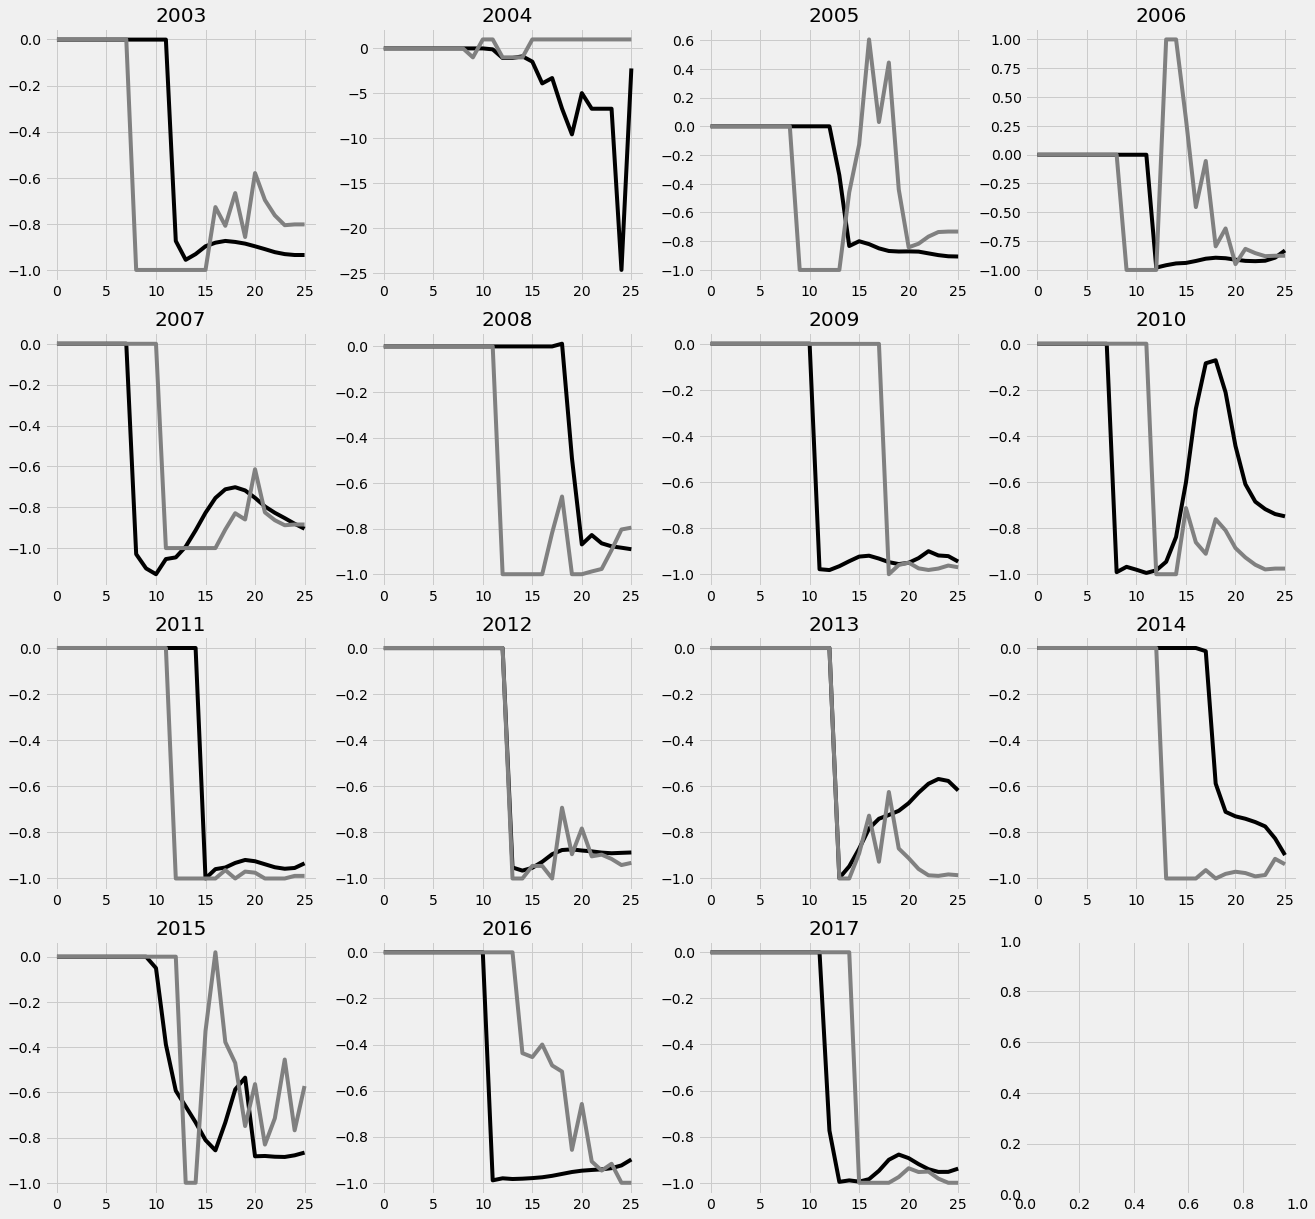

In [28]:
from sklearn.preprocessing import MinMaxScaler

X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale_nan = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
# Y_scale = np.nan_to_num(Y_scale)
Y_scale_nan = np.nan_to_num(Y_scale)

fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(20)
fig.set_figheight(20)
ymax = 0
for j, year in enumerate(analysis_years):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(64, input_shape=(26, 5),
                   return_sequences=True,
                   activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.LSTM(64, input_shape=(26, 5),
                   return_sequences=True,
                   activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.LSTM(64, input_shape=(26, 5),
                   return_sequences=True,
                   activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.LSTM(64, input_shape=(26, 5),
                   return_sequences=True,
                   activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='adam', 
                  loss='mae')
    ind = np.ones((len(analysis_years),), bool)
    ind[j] = False
    train_X = np.nan_to_num(X_scale_nan[ind])
    train_Y = np.nan_to_num(Y_scale_nan[ind])

    test_X = np.nan_to_num(X_scale_nan[j].reshape(1, X_scale_nan.shape[1], X_scale_nan.shape[2]))
    test_Y = np.nan_to_num(Y_scale_nan[j].reshape(1, Y_scale_nan.shape[1], Y_scale_nan.shape[2]))
    
    history = model.fit(train_X, train_Y, 
                    epochs=2000, batch_size=16,)
    
    train_predictions = model.predict(train_X)

    # Train RMSE
    train_mse = metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                               train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))
    
    test_predictions = model.predict(test_X)

    # Test RMSE
    test_mse = metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                               test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))
    
    print('###################')
    print(f'Train MAE for {year} is {train_mse}')
    print(f'Test MAE for {year} is {test_mse}')
    print('###################')
    
    jx = np.unravel_index(j, ax.shape)
    
    ax[jx].plot(test_predictions[0], color='black')
    ax[jx].plot(test_Y[0], color='gray')
    ax[jx].set_title(year)
    
    # Save for future use
    model.save(f'models/model_{year}.h5')

### Example code

#### For data augmentation

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# X_scale = np.copy(X)
# scalers_x = {}
# for i in range(X.shape[1]):
#     scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
#     X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
# X_scale_nan = np.nan_to_num(X_scale)

# # Augmenting training data - X
# X_reverse_time = reverse_time_series(X_scale_nan)
# X_reverse_magnitude = X_scale_nan * -1
# X_reverse_both = reverse_time_series(X_scale_nan) * -1

# # X_augmented = np.concatenate([X_scale_nan, X_reverse_time, X_reverse_magnitude, X_reverse_both])
# X_augmented = np.concatenate([X_scale_nan, X_reverse_time])

# Y_scale = np.copy(Y)
# scalers_y = {}
# for i in range(Y.shape[1]):
#     scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
#     Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
# # Y_scale = np.nan_to_num(Y_scale)
# Y_scale_nan = np.nan_to_num(Y_scale)

# # Augmenting training data - Y
# Y_reverse_time = reverse_time_series(Y_scale_nan)
# Y_reverse_magnitude = Y_scale_nan * -1
# Y_reverse_both = reverse_time_series(Y_scale_nan) * -1

# # Y_augmented = np.concatenate([Y_scale_nan, Y_reverse_time, Y_reverse_magnitude, Y_reverse_both])
# Y_augmented = np.concatenate([Y_scale_nan, Y_reverse_time])